In [1]:
import os
import gc
import sys
import itertools
import zipfile
from datetime import datetime

import numpy as np
import pandas as pd
import sqlite3 as sql
import pytz
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    recall_score,
    precision_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


brasil_tz = pytz.timezone('America/Sao_Paulo')

In [2]:
def baixar_arquivo_direto(url, nome_arquivo_local):
    """
    Verifica se um arquivo existe. Se não, baixa de uma URL
    (GitHub, OpenDataSUS, etc.)
    """
    if os.path.exists(nome_arquivo_local):
        print(f"✓ Arquivo '{nome_arquivo_local}' já existe.")
        return True

    print(f"Baixando '{nome_arquivo_local}' de {url}...")
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        with requests.get(url, stream=True, headers=headers) as r:
            r.raise_for_status() # Lança um erro se a URL estiver quebrada (404, 500)
            with open(nome_arquivo_local, 'wb') as f:
                for data in r.iter_content(8192):
                    f.write(data)
        print(f"✓ Download de '{nome_arquivo_local}' concluído.")
        return True
    except requests.exceptions.RequestException as e:
        print(f"\nERRO: Falha ao baixar o arquivo direto: {e}")
        if os.path.exists(nome_arquivo_local):
            os.remove(nome_arquivo_local)
        return False

In [3]:
def baixar_dados_mortalidade(ano):
    """
    Verifica se o arquivo CSV de mortalidade de um ano específico existe localmente.
    Se não existir, faz o download da fonte oficial do OPENDATASUS.
    """

    # O script usa este nome localmente
    nome_arquivo_local = f"Mortalidade_Geral_{ano}.csv"

    # 1. Verifica se o arquivo já existe localmente
    if os.path.exists(nome_arquivo_local):
        print(f"[{ano}] Arquivo {nome_arquivo_local} já existe localmente. Download pulado.")
        return True

    # 2. Se não existir, define a URL oficial do OpenDataSUS
    print(f"[{ano}] Arquivo {nome_arquivo_local} não encontrado. Iniciando download da fonte oficial...")

    # Padrão de URL do OpenDataSUS (ex: 2023 -> '23')
    ano_curto = str(ano)[2:]
    nome_arquivo_remoto = f"DO{ano_curto}OPEN.csv"

    url_base = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/"
    url = f"{url_base}{nome_arquivo_remoto}"

    try:
        # 3. Faz o download (stream=True é bom para arquivos grandes)
        with requests.get(url, stream=True) as r:
            r.raise_for_status() # Lança um erro se a URL estiver quebrada (404, 500)

            # Pega o tamanho total do arquivo (para barra de progresso)
            total_size = int(r.headers.get('content-length', 0))
            bloco_size = 8192 # 8KB

            # Salva o arquivo com o NOME LOCAL esperado pelo script
            with open(nome_arquivo_local, 'wb') as f:
                # Barra de progresso simples
                for i, data in enumerate(r.iter_content(bloco_size)):
                    f.write(data)
                    # Imprime o progresso a cada 100 blocos
                    if i % 100 == 0:
                        baixado = i * bloco_size
                        if total_size > 0:
                            percent = (baixado / total_size) * 100
                            sys.stdout.write(f"\r[{ano}] Baixando {nome_arquivo_remoto}... {percent:.1f}% ({baixado/1024/1024:.1f} MB)")
                        else:
                            sys.stdout.write(f"\r[{ano}] Baixando {nome_arquivo_remoto}... ({baixado/1024/1024:.1f} MB)")

            sys.stdout.write(f"\r[{ano}] Download de {nome_arquivo_remoto} concluído. Salvo como {nome_arquivo_local}. \n")
        return True

    except requests.exceptions.RequestException as e:
        print(f"\nERRO: Falha ao baixar o arquivo de {ano} da URL oficial: {url}")
        print(f"Detalhe: {e}")
        # Se o arquivo não existir na fonte (ex: 2024 pode não estar como DO24OPEN.csv ainda)
        if "404 Client Error" in str(e) or "403 Client Error" in str(e):
             print(f"[{ano}] Aviso: O arquivo {nome_arquivo_remoto} pode ainda não estar disponível no OpenDataSUS. Pulando este ano.")
             return False
        return False
    except Exception as e:
        print(f"\nERRO inesperado durante o download de {ano}: {e}")
        return False

In [4]:
def valor_padrao(valor, padrao=-1):
    if pd.isna(valor) or str(valor).strip() == "":
        return padrao
    return valor

In [5]:
def criar_sexo(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_SEXO""")
  cursor.execute("""
  INSERT INTO DWCD_SEXO VALUES
  (-1, '-1', 'Inválido', ?),
  (1, '1', 'Masculino', ?),
  (2, 'M', 'Masculino', ?),
  (3, '2', 'Feminino', ?),
  (4, 'F', 'Feminino', ?),
  (5, 'I', 'Ignorado', ?),
  (6, '0', 'Ignorado', ?),
  (7, '9', 'Ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora, agora, agora))

In [6]:
def criar_raca(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_RACA""")
  cursor.execute("""
  INSERT INTO DWCD_RACA VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'Branca', ?),
  (2, 2, 'Preta', ?),
  (3, 3, 'Amarela', ?),
  (4, 4, 'Parda', ?),
  (5, 5, 'Indígena', ?)
  """, (agora, agora, agora, agora, agora, agora))

In [7]:
def criar_obito_puerperio(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_OBITO_PUERPERIO""")
  cursor.execute("""
  INSERT INTO DWCD_OBITO_PUERPERIO
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'Sim, até 42 dias após o parto', ?),
  (2, 2, 'Sim, de 43 dias a 1 ano', ?),
  (3, 3, 'Não', ?),
  (4, 9, 'Ignorado', ?)
  """, (agora, agora, agora, agora, agora))

In [8]:
def criar_ocorrencia_obito(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_OCORRENCIA_OBITO""")
  cursor.execute("""
  INSERT INTO DWCD_OCORRENCIA_OBITO
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'Na gravidez', ?),
  (2, 2, 'No parto', ?),
  (3, 3, 'No abortamento', ?),
  (4, 4, 'Até 42 dias após o término do parto', ?),
  (5, 5, 'De 43 dias a 1 ano após o término da gestação', ?),
  (6, 8, 'Não ocorreu nestes períodos', ?),
  (7, 9, 'Ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora, agora, agora))

In [9]:
def criar_fonte_informacoes(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_FONTE_INFORMACAO""")
  cursor.execute("""
  INSERT INTO DWCD_FONTE_INFORMACAO
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'ocorrência policial', ?),
  (2, 2, 'hospital', ?),
  (3, 3, 'família', ?),
  (4, 4, 'outra', ?),
  (5, 9, 'ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora))

In [10]:
def criar_local_tipo_ocorrencia(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_LOCAL_TIPO_OCORRENCIA""")
  cursor.execute("""
  INSERT INTO DWCD_LOCAL_TIPO_OCORRENCIA
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'via pública', ?),
  (2, 2, 'endereço de residência', ?),
  (3, 3, 'outro domicílio', ?),
  (4, 4, 'estabelecimento comercial', ?),
  (5, 5, 'outros', ?),
  (6, 9, 'ignorada', ?)
  """, (agora, agora, agora, agora, agora, agora, agora))

In [11]:
def criar_metodo_parto(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_METODO_PARTO""")
  cursor.execute("""
  INSERT INTO DWCD_METODO_PARTO
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'vaginal', ?),
  (2, 2, 'cesáreo', ?),
  (3, 9, 'ignorado', ?)
  """, (agora, agora, agora, agora))

In [12]:
def criar_escolaridade(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_ESCOLARIDADE""")
  cursor.execute("""
  INSERT INTO DWCD_ESCOLARIDADE
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 0, 'Sem escolaridade', ?),
  (2, 1, 'Fundamental I (1ª a 4ª série)', ?),
  (3, 2, 'Fundamental II (5ª a 8ª série)', ?),
  (4, 3, 'Médio (antigo 2º Grau)', ?),
  (5, 4, 'Superior incompleto', ?),
  (6, 5, 'Superior completo', ?),
  (7, 9, 'Ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora, agora, agora))

In [13]:
def criar_local_ocorrencia(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_LOCAL_OCORRENCIA""")
  cursor.execute("""
  INSERT INTO DWCD_LOCAL_OCORRENCIA
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'hospital', ?),
  (2, 2, 'outros estabelecimentos de saúde', ?),
  (3, 3, 'domicílio', ?),
  (4, 4, 'via pública', ?),
  (5, 5, 'outros', ?),
  (6, 6, 'aldeia indígena', ?),
  (7, 9, 'ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora, agora, agora))

In [14]:
def criar_estado_civil(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_ESTADO_CIVIL""")
  cursor.execute("""
  INSERT INTO DWCD_ESTADO_CIVIL
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'Solteiro', ?),
  (2, 2, 'Casado', ?),
  (3, 3, 'Viúvo', ?),
  (4, 4, 'Separado judicialmente/divorciado', ?),
  (5, 5, 'União estável', ?),
  (6, 9, 'Ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora, agora))


In [15]:
def criar_circunstancia_obito(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_CIRCUNSTANCIA_OBITO""")
  cursor.execute("""
  INSERT INTO DWCD_CIRCUNSTANCIA_OBITO
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'acidente', ?),
  (2, 2, 'suicídio', ?),
  (3, 3, 'homicídio', ?),
  (4, 4, 'outros', ?) ,
  (5, 9, 'ignorado', ?)
  """, (agora, agora, agora, agora, agora, agora))

In [16]:
def criar_tipo_gravidez(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_GESTACAO_MULTIPLA""")
  cursor.execute("""
  INSERT INTO DWCD_GESTACAO_MULTIPLA
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'única', ?),
  (2, 2, 'dupla', ?),
  (3, 3, 'tripla e mais', ?),
  (4, 9, 'ignorado', ?)
  """, (agora, agora, agora, agora, agora))

In [17]:
def limpar_pessoa_obito(cursor):
  cursor.execute("""DELETE FROM DWMV_OBITO""")
  cursor.execute("""DELETE FROM DWCD_PESSOA""")

In [18]:
def criar_pessoa_obito(cursor, caminho, ano):
    batch_size = 32677

    cursor.execute("SELECT SK_Dados_Demograficos FROM DWMV_Obito WHERE DT_Data LIKE ?", ('%' + str(ano),))
    sks_demograficos = cursor.fetchall()

    if sks_demograficos:
        lista_sks = [sk[0] for sk in sks_demograficos]
        cursor.execute("DELETE FROM DWMV_Obito WHERE DT_Data LIKE ?", ('%' + str(ano),))
        print(f"Deleted {len(lista_sks)} records from DWMV_Obito.")

        for i in range(0, len(lista_sks), batch_size):
            batch = lista_sks[i:i + batch_size]
            placeholders = ', '.join(['?'] * len(batch))
            cursor.execute(f"DELETE FROM DWCD_DADOS_DEMOGRAFICOS WHERE SK_Dados_Demograficos IN ({placeholders})", batch)
    else:
        print("No records found for the specified year.")

    df_cru = pd.read_csv(caminho, sep=';', quotechar='"', dtype=str, encoding='ISO-8859-1')
    df_cru['LINHAA'] = df_cru['LINHAA'].str.replace(r"\*|X$", "", regex=True)
    df_cru['HORAOBITO'] = df_cru['HORAOBITO'].astype(str).str.strip().replace({'nan': None})

    dt_times = pd.to_datetime(df_cru['HORAOBITO'], format='%H%M', errors='coerce')

    df_cru['HORAOBITO'] = dt_times.dt.strftime('%H:%M:%S')
    df_cru['HORAOBITO'] = df_cru['HORAOBITO'].where(df_cru['HORAOBITO'].notna(), None)

    df_cru['HORA'] = dt_times.dt.hour
    df_cru['HORA'] = df_cru['HORA'].where(df_cru['HORA'].notna(), None)
    df_cru = df_cru.replace("", -1).fillna(-1)
    df_cru['IDADE'] = pd.to_numeric(df_cru['IDADE'], errors='coerce')

    # Regra 1: Trata idades no formato SIM (4xx = xx anos)
    # Ex: 450 vira 50
    df_cru.loc[(df_cru['IDADE'] >= 400) & (df_cru['IDADE'] <= 599), 'IDADE'] = df_cru['IDADE'] - 400

    # Regra 2: Trata códigos de 'ignorado' (ex: 999) como -1
    df_cru.loc[df_cru['IDADE'] > 900, 'IDADE'] = -1

    # Regra 3: Trata idades impossíveis (ex: > 125) como -1
    df_cru.loc[df_cru['IDADE'] > 125, 'IDADE'] = -1
    agora = datetime.now(brasil_tz)
    agora = agora.strftime('%Y-%m-%d %H:%M:%S')

    nm_arquivo = os.path.basename(caminho)

    sexo_map = dict(cursor.execute("SELECT CAST(CD_Sexo AS TEXT), SK_Sexo FROM DWCD_SEXO").fetchall())
    raca_map = dict(cursor.execute("SELECT CAST(CD_Raca AS TEXT), SK_Raca FROM DWCD_RACA").fetchall())
    ocupacao_map = dict(cursor.execute("SELECT CAST(CD_Ocupacao AS TEXT), SK_Ocupacao FROM DWCD_OCUPACAO").fetchall())
    estado_civil_map = dict(cursor.execute("SELECT CAST(CD_Estado_Civil AS TEXT), SK_Estado_Civil FROM DWCD_ESTADO_CIVIL").fetchall())
    escolaridade_map = dict(cursor.execute("SELECT CAST(CD_Escolaridade AS TEXT), SK_Escolaridade FROM DWCD_ESCOLARIDADE").fetchall())
    municipio_map = dict(cursor.execute("SELECT CAST(CD_Municipio AS TEXT), SK_Municipio FROM DWCD_MUNICIPIO").fetchall())
    local_ocorrencia_map = dict(cursor.execute("SELECT CAST(CD_Local_Ocorrencia AS TEXT), SK_Local_Ocorrencia FROM DWCD_LOCAL_OCORRENCIA").fetchall())
    escolaridade_mae_map = escolaridade_map
    gestacao_multipla_map = dict(cursor.execute("SELECT CAST(CD_Gestacao_Multipla AS TEXT), SK_Gestacao_Multipla FROM DWCD_GESTACAO_MULTIPLA").fetchall())
    metodo_parto_map = dict(cursor.execute("SELECT CAST(CD_Metodo_Parto AS TEXT), SK_Metodo_Parto FROM DWCD_METODO_PARTO").fetchall())
    obito_parto_map = dict(cursor.execute("SELECT CAST(CD_Obito_Parto AS TEXT), SK_Obito_Parto FROM DWCD_OBITO_PARTO").fetchall())
    ocorrencia_obito_map = dict(cursor.execute("SELECT CAST(CD_Ocorrencia_Obito AS TEXT), SK_Ocorrencia_Obito FROM DWCD_OCORRENCIA_OBITO").fetchall())
    circunstancia_obito_map = dict(cursor.execute("SELECT CAST(CD_Circunstancia_Obito AS TEXT), SK_Circunstancia_Obito FROM DWCD_CIRCUNSTANCIA_OBITO").fetchall())
    fonte_informacao_map = dict(cursor.execute("SELECT CAST(CD_Fonte_Informacao AS TEXT), SK_Fonte_Informacao FROM DWCD_FONTE_INFORMACAO").fetchall())
    local_tipo_ocorrencia_map = dict(cursor.execute("SELECT CAST(CD_Local_Tipo_Ocorrencia AS TEXT), SK_Local_Tipo_Ocorrencia FROM DWCD_LOCAL_TIPO_OCORRENCIA").fetchall())
    obito_puerperio_map = dict(cursor.execute("SELECT CAST(CD_Obito_Puerperio AS TEXT), SK_Obito_Puerperio FROM DWCD_OBITO_PUERPERIO").fetchall())
    cid_map = dict(cursor.execute("SELECT CAST(CD_CID AS TEXT), SK_CID FROM DWCD_CID").fetchall())

    cursor.execute("SELECT COALESCE(MAX(SK_Dados_Demograficos), 0) FROM DWCD_DADOS_DEMOGRAFICOS")
    last_sk = cursor.fetchone()[0]
    sk_generator = itertools.count(last_sk + 1)

    dados_pessoa_batch = []
    dados_obito_batch = []

    for linha in df_cru.itertuples(index=False):
        sk_novo = next(sk_generator)

        sexo_sk = sexo_map.get(linha.SEXO, -1)
        raca_sk = raca_map.get(linha.RACACOR, -1)
        estado_civil_sk = estado_civil_map.get(linha.ESTCIV, -1)
        escolaridade_sk = escolaridade_map.get(linha.ESC, -1)
        municipio_residencia_sk = municipio_map.get(linha.CODMUNRES, -1)
        ocupacao_sk = ocupacao_map.get(linha.OCUP, -1)

        dados_pessoa_batch.append((
            sk_novo,
            nm_arquivo,
            sexo_sk,
            municipio_residencia_sk,
            raca_sk,
            estado_civil_sk,
            escolaridade_sk,
            ocupacao_sk,
            linha.NATURAL,
            linha.IDADE,
            linha.DTNASC,
            agora
        ))

        local_ocorrencia_sk = local_ocorrencia_map.get(linha.LOCOCOR, -1)
        municipio_ocorrencia_sk = municipio_map.get(linha.CODMUNOCOR, -1)
        escolaridade_mae_sk = escolaridade_mae_map.get(linha.ESCMAE2010, -1)
        gestacao_multipla_sk = gestacao_multipla_map.get(linha.GRAVIDEZ, -1)
        metodo_parto_sk = metodo_parto_map.get(linha.PARTO, -1)
        obito_parto_sk = obito_parto_map.get(linha.OBITOPARTO, -1)
        ocorrencia_obito_sk = ocorrencia_obito_map.get(linha.TPMORTEOCO, -1)
        circunstancia_obito_sk = circunstancia_obito_map.get(linha.CIRCOBITO, -1)
        fonte_informacao_sk = fonte_informacao_map.get(linha.FONTE, -1)
        local_tipo_ocorrencia_sk = local_tipo_ocorrencia_map.get(linha.TPOBITOCOR, -1)
        obito_puerperio_sk = obito_puerperio_map.get(linha.OBITOPUERP, -1)
        cid_sk = cid_map.get(linha.LINHAA, -1)
        ocupacao_mae_sk = ocupacao_map.get(linha.OCUPMAE, -1)
        causa_basica_sk = cid_map.get(linha.CAUSABAS, -1)

        dados_obito_batch.append((
            sk_novo,
            linha.TIPOBITO,
            linha.DTOBITO,
            linha.HORA,
            linha.HORAOBITO,
            local_ocorrencia_sk,
            municipio_ocorrencia_sk,
            linha.CODESTAB,
            linha.IDADEMAE,
            escolaridade_mae_sk,
            ocupacao_mae_sk,
            linha.QTDFILVIVO,
            linha.QTDFILMORT,
            linha.SEMAGESTAC,
            gestacao_multipla_sk,
            metodo_parto_sk,
            obito_parto_sk,
            linha.PESO,
            ocorrencia_obito_sk,
            linha.ASSISTMED,
            linha.NECROPSIA,
            cid_sk,
            causa_basica_sk,
            linha.ATESTANTE,
            linha.COMUNSVOIM,
            linha.DTATESTADO,
            circunstancia_obito_sk,
            linha.ACIDTRAB,
            fonte_informacao_sk,
            local_tipo_ocorrencia_sk,
            obito_puerperio_sk,
            linha.EXAME,
            linha.CIRURGIA,
            agora
        ))


    cursor.executemany("""
        INSERT INTO DWCD_DADOS_DEMOGRAFICOS (
            SK_Dados_Demograficos, NM_Arquivo, SK_Sexo, SK_Municipio_Residencia,
            SK_Raca, SK_Estado_Civil, SK_Escolaridade, SK_Ocupacao, SK_Naturalidade,
            DS_Idade, DT_Nascimento, DT_Carga
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, dados_pessoa_batch)

    cursor.executemany("""
        INSERT INTO DWMV_OBITO (
            SK_Dados_Demograficos, ST_Obito_Fetal, DT_Data, DT_Hora, DT_Hora_Minuto, SK_Local_Ocorrencia, SK_Municipio,
            DS_Estabelecimento, DS_Idade_Mae, SK_Escolaridade_Mae, SK_Ocupacao_Mae, DS_Filhos_Vivos,
            DS_Filhos_Perdidos, DS_Semanas_Gestacao, SK_Gestacao_Multipla, SK_Metodo_Parto, SK_Obito_Parto,
            DS_Peso_Nascimento, SK_Ocorrencia_Obito, ST_Assistencia_Medica, ST_Necropsia, SK_CID,
            SK_Causa_Basica, DS_Atestado_Medico, DS_Municipio_SVO_IML, DT_Atestado, SK_Circunstancia_Obito,
            ST_Acidente_Trabalho, SK_Fonte_Informacao, SK_Local_Tipo_Ocorrencia_Acidente, SK_Obito_Puerperio,
            ST_Exame, ST_Cirurgia, DT_Carga
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, dados_obito_batch)

    del df_cru, dados_pessoa_batch, dados_obito_batch
    gc.collect()


In [19]:
def criar_municipios(cursor, caminho):
    agora = datetime.now(brasil_tz).strftime('%Y-%m-%d %H:%M:%S')

    df_cru = pd.read_excel(caminho, skiprows=6, header=None)
    df_cru.columns = df_cru.iloc[0]
    df_municipio = df_cru[1:].reset_index(drop=True)

    cursor.execute("""
    INSERT INTO DWCD_MUNICIPIO (SK_Municipio, CD_Municipio, NM_Municipio, SK_UF, DT_Carga)
    VALUES (?, ?, ?, ?, ?)
    ON CONFLICT(CD_Municipio) DO NOTHING
    """, (-1, -1, "Inválido", -1, agora))

    UF_map = dict(cursor.execute("SELECT CAST(\"CD_UF\" AS TEXT), SK_UF FROM DWCD_UF").fetchall())

    for _, row in df_municipio.iterrows():
        codigo_ibge = int(row['Código Município Completo'])  # 7 dígitos
        codigo_base = codigo_ibge // 10  # remove dígito verificador
        UF_sk = UF_map.get(row['UF'], -1)

        cursor.execute("""
        INSERT INTO DWCD_MUNICIPIO (CD_Municipio, NM_Municipio, SK_UF, DT_Carga)
        VALUES (?, ?, ?, ?)
        ON CONFLICT(CD_Municipio)
        DO UPDATE SET
            NM_Municipio = excluded.NM_Municipio,
            SK_UF = excluded.SK_UF,
            DT_Carga = excluded.DT_Carga
        """, (codigo_base, row['Nome_Município'], UF_sk, agora))

In [20]:
def criar_obito_parto(cursor):
  agora = datetime.now(brasil_tz)
  agora = agora.strftime('%Y-%m-%d %H:%M:%S')
  cursor.execute("""DELETE FROM DWCD_OBITO_PARTO""")
  cursor.execute("""
  INSERT INTO DWCD_OBITO_PARTO
  VALUES
  (-1, -1, 'Inválido', ?),
  (1, 1, 'antes', ?),
  (2, 2, 'durante', ?),
  (3, 3, 'depois', ?),
  (4, 9, 'Ignorado', ?)
  """, (agora, agora, agora, agora, agora))

In [21]:
def criar_cid(cursor, caminho):
    agora = datetime.now(brasil_tz).strftime('%Y-%m-%d %H:%M:%S')
    df_raw = pd.read_csv(caminho, sep=';', encoding='ISO-8859-1')
    cursor.execute("""
    INSERT INTO DWCD_CID (SK_CID, CD_CID, DS_CID, DT_Carga)
    VALUES (?, ?, ?, ?)
    ON CONFLICT(CD_CID) DO NOTHING
    """, (-1, -1, "Inválido", agora))

    for _, row in df_raw.iterrows():
        cursor.execute("""
        INSERT INTO DWCD_CID (CD_CID, DS_CID, DT_Carga)
        VALUES (?, ?, ?)
        ON CONFLICT(CD_CID)
        DO UPDATE SET
            DS_CID = excluded.DS_CID,
            DT_Carga = excluded.DT_Carga
        """, (row.get('SUBCAT'), row.get('DESCRICAO'), agora))

In [22]:
def criar_uf(cursor, caminho):
    agora = datetime.now(brasil_tz).strftime('%Y-%m-%d %H:%M:%S')
    df_cru = pd.read_excel(caminho, skiprows=6, header=None)
    df_cru.columns = df_cru.iloc[0]
    df_municipio = df_cru[1:].reset_index(drop=True)
    df_uf_cru = df_municipio[['UF', 'Nome_UF']]
    df_uf = df_uf_cru.drop_duplicates()
    cursor.execute("""
    INSERT INTO DWCD_UF (SK_UF, CD_UF, NM_UF, DT_Carga)
    VALUES (?, ?, ?, ?)
    ON CONFLICT(CD_UF) DO NOTHING
    """, (-1, -1, "Inválido", agora))

    for _, row in df_uf.iterrows():
        cursor.execute("""
        INSERT INTO DWCD_UF (CD_UF, NM_UF, DT_Carga)
        VALUES (?, ?, ?)
        ON CONFLICT(CD_UF)
        DO UPDATE SET
            NM_UF = excluded.NM_UF,
            DT_Carga = excluded.DT_Carga
        """, (row['UF'], row['Nome_UF'], agora))

In [23]:
def criar_ocupacao(cursor, caminho):
    agora = datetime.now(brasil_tz).strftime('%Y-%m-%d %H:%M:%S')
    df = pd.read_csv(caminho, sep=';', quotechar='"', encoding='ISO-8859-1')
    cursor.execute("""
    INSERT INTO DWCD_OCUPACAO (SK_Ocupacao, CD_Ocupacao, DS_Ocupacao, DT_Carga)
    VALUES (?, ?, ?, ?)
    ON CONFLICT(CD_Ocupacao) DO NOTHING
    """, (-1, -1, "Inválido", agora))

    for _, row in df.iterrows():
        cursor.execute("""
        INSERT INTO DWCD_OCUPACAO (CD_Ocupacao, DS_Ocupacao, DT_Carga)
        VALUES (?, ?, ?)
        ON CONFLICT(CD_Ocupacao)
        DO UPDATE SET
            DS_Ocupacao = excluded.DS_Ocupacao,
            DT_Carga = excluded.DT_Carga
        """, (row['CODIGO'], row['TITULO'], agora))

In [24]:
def criar_base_de_dados(cursor):
  cursor.executescript("""
CREATE TABLE IF NOT EXISTS "DWCD_OCUPACAO" (
	"SK_Ocupacao" INTEGER NOT NULL,
	"CD_Ocupacao" INTEGER NOT NULL UNIQUE,
	"DS_Ocupacao" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Ocupacao")
);

CREATE TABLE IF NOT EXISTS "DWCD_UF" (
	"SK_UF" INTEGER NOT NULL,
	"CD_UF" INTEGER NOT NULL UNIQUE,
	"NM_UF" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_UF")
);

CREATE TABLE IF NOT EXISTS "DWCD_OBITO_PARTO" (
	"SK_Obito_Parto" INTEGER NOT NULL,
	"CD_Obito_Parto" INTEGER NOT NULL UNIQUE,
	"DS_Obito_Parto" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Obito_Parto")
);

CREATE TABLE IF NOT EXISTS "DWCD_CID" (
	"SK_CID" INTEGER NOT NULL,
	"CD_CID" VARCHAR NOT NULL UNIQUE,
	"DS_CID" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_CID")
);

CREATE TABLE IF NOT EXISTS "DWCD_DADOS_DEMOGRAFICOS" (
	"SK_Dados_Demograficos" INTEGER NOT NULL,
	"NM_Arquivo" VARCHAR NOT NULL,
	"SK_Sexo" INTEGER NOT NULL,
	"SK_Municipio_Residencia" INTEGER NOT NULL,
	"SK_Raca" INTEGER,
	"SK_Estado_Civil" INTEGER,
	"SK_Escolaridade" INTEGER,
	"SK_Ocupacao" INTEGER,
	"SK_Naturalidade" INTEGER,
	"DS_Idade" INTEGER,
	"DT_Nascimento" DATE,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Dados_Demograficos", "NM_Arquivo", "SK_Sexo", "SK_Municipio_Residencia"),
	FOREIGN KEY ("SK_Estado_Civil") REFERENCES "DWCD_ESTADO_CIVIL"("SK_Estado_Civil")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Raca") REFERENCES "DWCD_RACA"("SK_Raca")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Sexo") REFERENCES "DWCD_SEXO"("SK_Sexo")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Municipio_Residencia") REFERENCES "DWCD_MUNICIPIO"("SK_Municipio")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Naturalidade") REFERENCES "DWCD_MUNICIPIO"("SK_Municipio")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Escolaridade") REFERENCES "DWCD_ESCOLARIDADE"("SK_Escolaridade")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Ocupacao") REFERENCES "DWCD_OCUPACAO"("SK_Ocupacao")
	ON UPDATE NO ACTION ON DELETE NO ACTION
);

CREATE TABLE IF NOT EXISTS "DWMV_OBITO" (
	"SK_Dados_Demograficos" INTEGER NOT NULL UNIQUE,
	"SK_CID" INTEGER NOT NULL,
	"SK_Municipio" INTEGER NOT NULL,
	"SK_Local_Ocorrencia" INTEGER NOT NULL,
	"ST_Obito_Fetal" INTEGER NOT NULL,
	"DT_Data" DATE NOT NULL,
	"SK_Obito_Parto" INTEGER,
	"SK_Causa_Basica" INTEGER,
	"SK_Escolaridade_Mae" INTEGER,
	"SK_Ocupacao_Mae" INTEGER,
	"SK_Gestacao_Multipla" INTEGER,
	"SK_Metodo_Parto" INTEGER,
	"SK_Ocorrencia_Obito" INTEGER,
	"SK_Circunstancia_Obito" INTEGER,
	"SK_Local_Tipo_Ocorrencia_Acidente" INTEGER,
	"SK_Fonte_Informacao" INTEGER,
	"SK_Obito_Puerperio" INTEGER,
	"DT_Hora_Minuto" TIME,
	"DT_Hora" INTEGER,
	"DS_Estabelecimento" INTEGER,
	"DS_Idade_Mae" INTEGER,
	"DS_Filhos_Vivos" INTEGER,
	"DS_Filhos_Perdidos" INTEGER,
	"DS_Semanas_Gestacao" INTEGER,
	"DS_Peso_Nascimento" INTEGER,
	"DS_Atestado_Medico" INTEGER,
	"DS_Municipio_SVO_IML" INTEGER,
	"DT_Atestado" DATE,
	"ST_Necropsia" INTEGER,
	"ST_Acidente_Trabalho" INTEGER,
	"ST_Assistencia_Medica" INTEGER,
	"ST_Exame" INTEGER,
	"ST_Cirurgia" INTEGER,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Dados_Demograficos", "SK_CID", "SK_Municipio", "SK_Local_Ocorrencia", "ST_Obito_Fetal", "DT_Data"),
	FOREIGN KEY ("SK_Local_Ocorrencia") REFERENCES "DWCD_LOCAL_OCORRENCIA"("SK_Local_Ocorrencia")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Municipio") REFERENCES "DWCD_MUNICIPIO"("SK_Municipio")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Escolaridade_Mae") REFERENCES "DWCD_ESCOLARIDADE"("SK_Escolaridade")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Obito_Puerperio") REFERENCES "DWCD_OBITO_PUERPERIO"("SK_Obito_Puerperio")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Causa_Basica") REFERENCES "DWCD_CID"("SK_CID")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_CID") REFERENCES "DWCD_CID"("SK_CID")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Obito_Parto") REFERENCES "DWCD_OBITO_PARTO"("SK_Obito_Parto")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Local_Tipo_Ocorrencia_Acidente") REFERENCES "DWCD_LOCAL_TIPO_OCORRENCIA"("SK_Local_Tipo_Ocorrencia")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Fonte_Informacao") REFERENCES "DWCD_FONTE_INFORMACAO"("SK_Fonte_Informacao")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Circunstancia_Obito") REFERENCES "DWCD_CIRCUSTANCIA_OBITO"("SK_Circunstancia_Obito")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Ocorrencia_Obito") REFERENCES "DWCD_OCORRENCIA_OBITO"("SK_Ocorrencia_Obito")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Metodo_Parto") REFERENCES "DWCD_METODO_PARTO"("SK_Metodo_Parto")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Gestacao_Multipla") REFERENCES "DWCD_GESTACAO_MULTIPLA"("SK_Gestacao_Multipla")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Ocupacao_Mae") REFERENCES "DWCD_OCUPACAO"("SK_Ocupacao")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("SK_Dados_Demograficos") REFERENCES "DWCD_DADOS_DEMOGRAFICOS"("SK_Dados_Demograficos")
	ON UPDATE NO ACTION ON DELETE NO ACTION
);

CREATE TABLE IF NOT EXISTS "DWCD_GESTACAO_MULTIPLA" (
	"SK_Gestacao_Multipla" INTEGER NOT NULL,
	"CD_Gestacao_Multipla" INTEGER NOT NULL UNIQUE,
	"DS_Gestacao_Multipla" VARCHAR NOT NULL UNIQUE,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Gestacao_Multipla")
);

CREATE TABLE IF NOT EXISTS "DWCD_MUNICIPIO" (
	"SK_Municipio" INTEGER NOT NULL,
	"CD_Municipio" INTEGER NOT NULL UNIQUE,
	"NM_Municipio" VARCHAR NOT NULL,
	"SK_UF" INTEGER NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Municipio"),
	FOREIGN KEY ("SK_UF") REFERENCES "DWCD_UF"("SK_UF")
	ON UPDATE NO ACTION ON DELETE NO ACTION
);

CREATE TABLE IF NOT EXISTS "DWCD_ESTADO_CIVIL" (
	"SK_Estado_Civil" INTEGER NOT NULL,
	"CD_Estado_Civil" INTEGER NOT NULL UNIQUE,
	"DS_Estado_Civil" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Estado_Civil")
);

CREATE TABLE IF NOT EXISTS "DWCD_LOCAL_OCORRENCIA" (
	"SK_Local_Ocorrencia" INTEGER NOT NULL,
	"CD_Local_Ocorrencia" INTEGER NOT NULL UNIQUE,
	"DS_Local_Ocorrencia" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Local_Ocorrencia")
);

CREATE TABLE IF NOT EXISTS "DWCD_ESCOLARIDADE" (
	"SK_Escolaridade" INTEGER NOT NULL,
	"CD_Escolaridade" INTEGER NOT NULL UNIQUE,
	"DS_Escolaridade" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Escolaridade")
);

CREATE TABLE IF NOT EXISTS "DWCD_METODO_PARTO" (
	"SK_Metodo_Parto" INTEGER NOT NULL,
	"CD_Metodo_Parto" INTEGER NOT NULL UNIQUE,
	"DS_Metodo_Parto" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Metodo_Parto")
);

CREATE TABLE IF NOT EXISTS "DWCD_OCORRENCIA_OBITO" (
	"SK_Ocorrencia_Obito" INTEGER NOT NULL,
	"CD_Ocorrencia_Obito" INTEGER NOT NULL UNIQUE,
	"DS_Ocorrencia_Obito" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Ocorrencia_Obito")
);

CREATE TABLE IF NOT EXISTS "DWCD_CIRCUNSTANCIA_OBITO" (
	"SK_Circunstancia_Obito" INTEGER NOT NULL,
	"CD_Circunstancia_Obito" INTEGER NOT NULL UNIQUE,
	"DS_Circunstancia_Obito" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Circunstancia_Obito")
);

CREATE TABLE IF NOT EXISTS "DWCD_FONTE_INFORMACAO" (
	"SK_Fonte_Informacao" INTEGER NOT NULL,
	"CD_Fonte_Informacao" INTEGER NOT NULL UNIQUE,
	"DS_Fonte_Informacao" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Fonte_Informacao")
);

CREATE TABLE IF NOT EXISTS "DWCD_LOCAL_TIPO_OCORRENCIA" (
	"SK_Local_Tipo_Ocorrencia" INTEGER NOT NULL,
	"CD_Local_Tipo_Ocorrencia" INTEGER NOT NULL UNIQUE,
	"DS_Local_Tipo_Ocorrencia" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Local_Tipo_Ocorrencia")
);

CREATE TABLE IF NOT EXISTS "DWCD_OBITO_PUERPERIO" (
	"SK_Obito_Puerperio" INTEGER NOT NULL,
	"CD_Obito_Puerperio" INTEGER NOT NULL UNIQUE,
	"DS_Obito_Puerperio" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Obito_Puerperio")
);

CREATE TABLE IF NOT EXISTS "DWCD_RACA" (
	"SK_Raca" INTEGER NOT NULL,
	"CD_Raca" INTEGER NOT NULL UNIQUE,
	"DS_Raca" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Raca")
);

CREATE TABLE IF NOT EXISTS "DWCD_SEXO" (
	"SK_Sexo" INTEGER NOT NULL,
	"CD_Sexo" VARCHAR NOT NULL UNIQUE,
	"DS_Sexo" VARCHAR NOT NULL,
	"DT_Carga" TIMESTAMP NOT NULL,
	PRIMARY KEY("SK_Sexo")
);
  """)

In [25]:
# (Cole isto no final do seu etl_dw.py, substituindo o 'with' antigo)

with sql.connect('mortalidade.db') as conn:
  cursor = conn.cursor()
  criar_base_de_dados(cursor)

  # --- Carga de Dimensões Estáticas (Usando SUAS funções) ---
  print("Carregando dimensões estáticas...")
  criar_sexo(cursor)
  criar_raca(cursor)
  criar_obito_puerperio(cursor)
  criar_escolaridade(cursor)
  criar_fonte_informacoes(cursor)
  criar_local_ocorrencia(cursor)
  criar_ocorrencia_obito(cursor)
  criar_local_tipo_ocorrencia(cursor)
  criar_metodo_parto(cursor)
  criar_estado_civil(cursor)
  criar_tipo_gravidez(cursor)       # (Sua função para Gestação Múltipla)
  criar_circunstancia_obito(cursor)
  criar_obito_parto(cursor)

  print("\n--- Verificando Arquivos de Dimensão Externa (Fontes Corrigidas) ---")

  # --- 1. IBGE Municípios (Do SEU GitHub) ---
  url_municipios = "https://raw.githubusercontent.com/MonoHenry/dadosparacd/main/RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.xls"
  arq_municipios_local = "RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.xls"
  ok_municipios = baixar_arquivo_direto(url_municipios, arq_municipios_local)

  # --- 2. CBO Ocupação (MTE - Link oficial) ---
  url_cbo = "https://www.gov.br/trabalho-e-emprego/pt-br/assuntos/cbo/servicos/downloads/cbo2002-ocupacao.csv"
  arq_cbo = "cbo2002-ocupacao.csv"
  ok_cbo = baixar_arquivo_direto(url_cbo, arq_cbo)

  # --- 3. CID-10 (Do SEU GitHub) ---
  url_cid = "https://raw.githubusercontent.com/MonoHenry/dadosparacd/main/CID-10-SUBCATEGORIAS.CSV"
  arq_cid_local = "CID-10-SUBCATEGORIAS.CSV"
  ok_cid = baixar_arquivo_direto(url_cid, arq_cid_local)

  # --- Carga de Dimensões Externas ---
  print("\n--- Carregando Dimensões Externas ---")

  if ok_municipios:
    print("Carregando Municípios e UFs...")
    criar_uf(cursor, arq_municipios_local)
    criar_municipios(cursor, arq_municipios_local)
  else:
    print(f"ERRO: Não foi possível carregar UFs e Municípios. Download do arquivo '{arq_municipios_local}' falhou.")

  if ok_cbo:
    print("Carregando Ocupações...")
    criar_ocupacao(cursor, arq_cbo)
  else:
    print(f"ERRO: Não foi possível carregar Ocupações. Download do arquivo '{arq_cbo}' falhou.")

  if ok_cid:
    print("Carregando CID...")
    criar_cid(cursor, arq_cid_local)
  else:
    print(f"ERRO: Não foi possível carregar CID. Download do arquivo '{arq_cid_local}' falhou.")

  # --- Carga Fato (Apenas 2023) ---
  print("\n--- Iniciando Carga Fato (Mortalidade) ---")

  ano = 2023

  print("---------------------------------------------------------")
  print(f"Iniciando processamento exclusivo do ano {ano}")

  nome_arquivo_local_fato = f"Mortalidade_Geral_{ano}.csv"
  ano_curto = str(ano)[2:]
  url_mortalidade = f"https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO{ano_curto}OPEN.csv"

  arquivo_ok = baixar_arquivo_direto(url_mortalidade, nome_arquivo_local_fato)

  # Verifica se TUDO o que é necessário foi baixado antes de processar
  if arquivo_ok and ok_municipios and ok_cbo and ok_cid:
      print("Dependências OK. Iniciando carga principal...")
      criar_pessoa_obito(cursor, nome_arquivo_local_fato, ano)
      print(f"Finalizado processamento de {ano}")
  else:
      print(f"FALHA: Não foi possível processar o ano {ano}.")
      print("Um ou mais arquivos de dependência falharam o download (Mortalidade, CID, CBO ou Municípios).")

  print("---------------------------------------------------------")
  print("Commit das transações...")
  conn.commit()
  print("Processo de ETL concluído.")

Carregando dimensões estáticas...

--- Verificando Arquivos de Dimensão Externa (Fontes Corrigidas) ---
Baixando 'RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.xls' de https://raw.githubusercontent.com/MonoHenry/dadosparacd/main/RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.xls...
✓ Download de 'RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.xls' concluído.
Baixando 'cbo2002-ocupacao.csv' de https://www.gov.br/trabalho-e-emprego/pt-br/assuntos/cbo/servicos/downloads/cbo2002-ocupacao.csv...
✓ Download de 'cbo2002-ocupacao.csv' concluído.
Baixando 'CID-10-SUBCATEGORIAS.CSV' de https://raw.githubusercontent.com/MonoHenry/dadosparacd/main/CID-10-SUBCATEGORIAS.CSV...
✓ Download de 'CID-10-SUBCATEGORIAS.CSV' concluído.

--- Carregando Dimensões Externas ---
Carregando Municípios e UFs...
Carregando Ocupações...
Carregando CID...

--- Iniciando Carga Fato (Mortalidade) ---
---------------------------------------------------------
Iniciando processamento exclusivo do ano 2023
Baixando 'Mortalidade_Geral_2023.csv' de http

/tmp/ipython-input-2948882027.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cru = df_cru.replace("", -1).fillna(-1)


Finalizado processamento de 2023
---------------------------------------------------------
Commit das transações...
Processo de ETL concluído.


--- INICIANDO DIAGNÓSTICO DA ETAPA 2 (Corrigido) ---
Analisando o ano: 2023

[Item 1/4] Gerando diagnóstico de INCONSISTÊNCIA (SEXO)...

--- Interpretação (Item 1: Inconsistência) ---
O script etl_dw.py resolveu a inconsistência dos códigos de SEXO.

ANTES (Dados Brutos):
|   Codigo_Bruto |   Contagem |
|---------------:|-----------:|
|              1 |     803200 |
|              2 |     661884 |
|              0 |        526 |

DEPOIS (Dados Limpos no DW):
| Sexo_Padronizado   |   Contagem |
|:-------------------|-----------:|
| Feminino           |     661884 |
| Ignorado           |        526 |
| Masculino          |     803200 |


/tmp/ipython-input-4245233204.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=consulta_antes_sexo, x='Codigo_Bruto', y='Contagem', palette='viridis')


Gráfico salvo: diagnostico_1_sexo_antes.png

[Item 2/4] Gerando diagnóstico de DADOS FALTANTES (Heatmap)...
Gráfico salvo: diagnostico_2_heatmap_antes.png

--- Interpretação (Item 2: Dados Faltantes) ---
O Heatmap (ANTES) mostra os 'buracos' nos dados brutos (linhas amarelas).
O script etl_dw.py mapeou os valores ausentes para a chave 'SK = -1' (Inválido).

DEPOIS (Contagem de 'SK = -1' no DW):
|   Contagem_Raca_Faltante |   Contagem_Esc_Faltante |   Contagem_EstCiv_Faltante |   Contagem_Ocup_Faltante |
|-------------------------:|------------------------:|---------------------------:|-------------------------:|
|                    23084 |                   89705 |                      66359 |                   857009 |

[Item 3/4] Gerando diagnóstico de OUTLIERS (IDADE)...
Gráfico salvo: diagnostico_3_boxplot_idade_antes.png

--- Interpretação (Item 3: Outliers de Idade) ---
O Box Plot (ANTES) mostra valores extremos (999) que são códigos de 'ignorado'.
O script etl_dw.py limpou isso

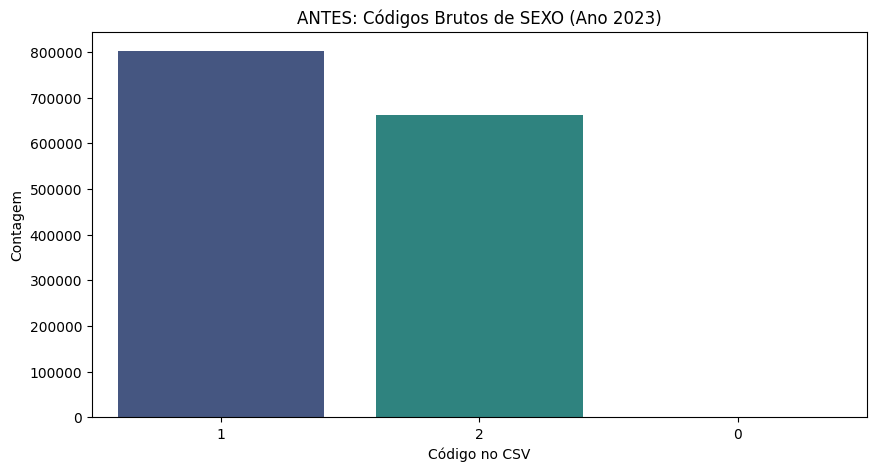

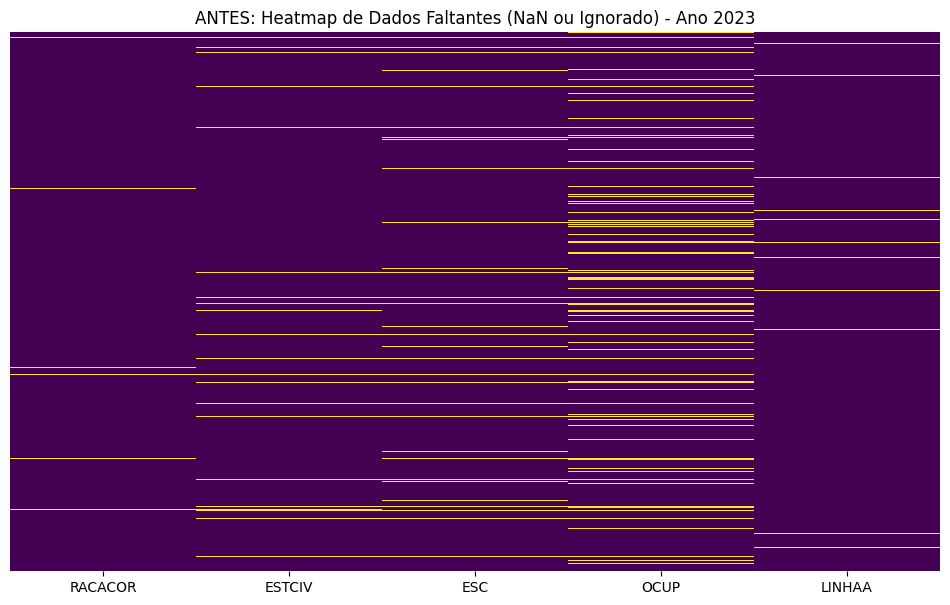

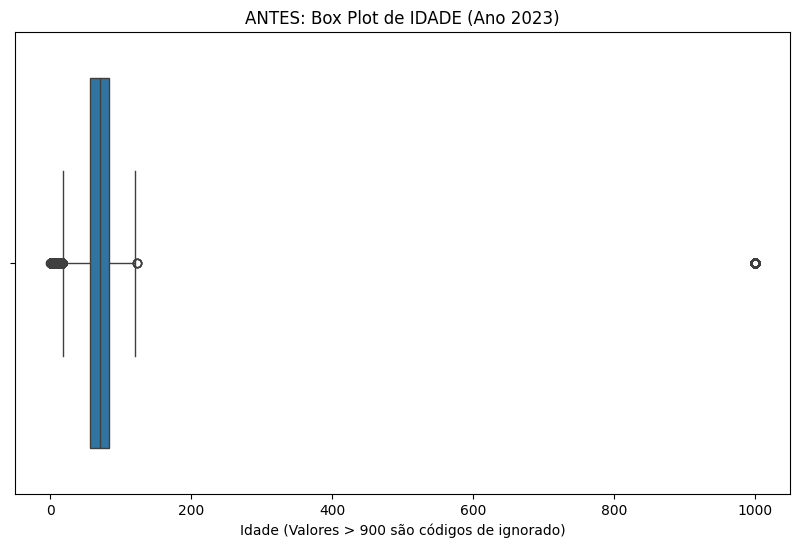

In [26]:
# --- Configurações ---
ARQUIVO_CSV_BRUTO = "Mortalidade_Geral_2023.csv"
BANCO_DADOS_LIMPO = "mortalidade.db"
ANO_ANALISE = 2023
PARAMETRO_ANO_LIKE = f"%{ANO_ANALISE}" # Usado para o formato DDMMYYYY

print("--- INICIANDO DIAGNÓSTICO DA ETAPA 2 (Corrigido) ---")
print(f"Analisando o ano: {ANO_ANALISE}")

# Verifica se os arquivos necessários existem
if not os.path.exists(ARQUIVO_CSV_BRUTO):
    print(f"ERRO: Arquivo bruto '{ARQUIVO_CSV_BRUTO}' não encontrado.")
    exit()
if not os.path.exists(BANCO_DADOS_LIMPO):
    print(f"ERRO: Banco de dados '{BANCO_DADOS_LIMPO}' não encontrado.")
    print("Por favor, execute o script etl_dw.py primeiro.")
    exit()

# Conecta ao banco de dados limpo
conn = sql.connect(BANCO_DADOS_LIMPO)

# --------------------------------------------------------------------
# ITEM 1: Diagnóstico de Inconsistência de Dados (Ex: SEXO)
# --------------------------------------------------------------------
print("\n[Item 1/4] Gerando diagnóstico de INCONSISTÊNCIA (SEXO)...")

# 1.1 ANTES (Dados Brutos do CSV)
df_bruto_sexo = pd.read_csv(ARQUIVO_CSV_BRUTO, sep=';', usecols=['SEXO'], dtype=str, encoding='ISO-8859-1')
consulta_antes_sexo = df_bruto_sexo['SEXO'].value_counts(dropna=False).reset_index()
consulta_antes_sexo.columns = ['Codigo_Bruto', 'Contagem']

# 1.2 DEPOIS (Dados Limpos do DB)
# CORREÇÃO: Alterado de strftime('%Y', ...) para LIKE '%2023'
consulta_depois_sexo = pd.read_sql_query("""
    SELECT
        T2.DS_Sexo AS Sexo_Padronizado,
        COUNT(T1.SK_Dados_Demograficos) AS Contagem
    FROM DWMV_OBITO AS T1
    JOIN DWCD_DADOS_DEMOGRAFICOS AS T_PESSOA ON T1.SK_Dados_Demograficos = T_PESSOA.SK_Dados_Demograficos
    JOIN DWCD_SEXO AS T2 ON T_PESSOA.SK_Sexo = T2.SK_Sexo
    WHERE T1.DT_Data LIKE ? -- CORREÇÃO AQUI (lê o formato DDMMYYYY)
    GROUP BY T2.DS_Sexo
""", conn, params=(PARAMETRO_ANO_LIKE,)) # Usa o parâmetro '%2023'

# 1.3 Interpretação e Visualização
print("\n--- Interpretação (Item 1: Inconsistência) ---")
print("O script etl_dw.py resolveu a inconsistência dos códigos de SEXO.\n")
print("ANTES (Dados Brutos):")
print(consulta_antes_sexo.to_markdown(index=False))
print("\nDEPOIS (Dados Limpos no DW):")
print(consulta_depois_sexo.to_markdown(index=False))

plt.figure(figsize=(10, 5))
sns.barplot(data=consulta_antes_sexo, x='Codigo_Bruto', y='Contagem', palette='viridis')
plt.title(f'ANTES: Códigos Brutos de SEXO (Ano {ANO_ANALISE})')
plt.xlabel('Código no CSV')
plt.ylabel('Contagem')
plt.savefig("diagnostico_1_sexo_antes.png")
print("Gráfico salvo: diagnostico_1_sexo_antes.png")


# --------------------------------------------------------------------
# ITEM 2: Diagnóstico de Dados Faltantes (Heatmap)
# --------------------------------------------------------------------
print("\n[Item 2/4] Gerando diagnóstico de DADOS FALTANTES (Heatmap)...")

# 2.1 ANTES (Dados Brutos do CSV)
colunas_heatmap = ['RACACOR', 'ESC', 'ESTCIV', 'OCUP', 'LINHAA']
df_bruto_missing = pd.read_csv(ARQUIVO_CSV_BRUTO, sep=';', usecols=colunas_heatmap, encoding='ISO-8859-1')
df_bruto_missing = df_bruto_missing.replace(r'^\s*$', np.nan, regex=True).replace('9', np.nan).replace('99', np.nan)

plt.figure(figsize=(12, 7))
sns.heatmap(df_bruto_missing.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title(f'ANTES: Heatmap de Dados Faltantes (NaN ou Ignorado) - Ano {ANO_ANALISE}')
plt.savefig("diagnostico_2_heatmap_antes.png")
print("Gráfico salvo: diagnostico_2_heatmap_antes.png")


# 2.2 DEPOIS (Dados Limpos do DB)
# CORREÇÃO: Alterado de strftime('%Y', ...) para LIKE '%2023' na subquery
consulta_depois_missing = pd.read_sql_query(f"""
    SELECT
        COUNT(CASE WHEN SK_Raca = -1 THEN 1 END) AS Contagem_Raca_Faltante,
        COUNT(CASE WHEN SK_Escolaridade = -1 THEN 1 END) AS Contagem_Esc_Faltante,
        COUNT(CASE WHEN SK_Estado_Civil = -1 THEN 1 END) AS Contagem_EstCiv_Faltante,
        COUNT(CASE WHEN SK_Ocupacao = -1 THEN 1 END) AS Contagem_Ocup_Faltante
    FROM DWCD_DADOS_DEMOGRAFICOS
    WHERE SK_Dados_Demograficos IN (
        SELECT SK_Dados_Demograficos FROM DWMV_OBITO
        WHERE DT_Data LIKE ? -- CORREÇÃO AQUI
    )
""", conn, params=(PARAMETRO_ANO_LIKE,))

# 2.3 Interpretação
print("\n--- Interpretação (Item 2: Dados Faltantes) ---")
print("O Heatmap (ANTES) mostra os 'buracos' nos dados brutos (linhas amarelas).")
print("O script etl_dw.py mapeou os valores ausentes para a chave 'SK = -1' (Inválido).\n")
print("DEPOIS (Contagem de 'SK = -1' no DW):")
print(consulta_depois_missing.to_markdown(index=False))


# --------------------------------------------------------------------
# ITEM 3: Diagnóstico de Outliers (Ex: IDADE)
# --------------------------------------------------------------------
print("\n[Item 3/4] Gerando diagnóstico de OUTLIERS (IDADE)...")

# 3.1 ANTES (Dados Brutos do CSV)
df_bruto_idade = pd.read_csv(ARQUIVO_CSV_BRUTO, sep=';', usecols=['IDADE'], encoding='ISO-8859-1')
def tratar_idade_bruta(idade_str):
    if pd.isna(idade_str) or not str(idade_str).isdigit():
        return np.nan
    idade = int(idade_str)
    if idade > 900: return idade
    if idade >= 400 and idade <= 599: return idade - 400
    if idade < 100: return idade
    return np.nan
df_bruto_idade['Idade_Tratada'] = df_bruto_idade['IDADE'].apply(tratar_idade_bruta)

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_bruto_idade['Idade_Tratada'])
plt.title(f'ANTES: Box Plot de IDADE (Ano {ANO_ANALISE})')
plt.xlabel('Idade (Valores > 900 são códigos de ignorado)')
plt.savefig("diagnostico_3_boxplot_idade_antes.png")
print("Gráfico salvo: diagnostico_3_boxplot_idade_antes.png")


# 3.2 DEPOIS (Dados Limpos do DB)
# CORREÇÃO: Alterado de strftime('%Y', ...) para LIKE '%2023' na subquery
consulta_depois_idade = pd.read_sql_query(f"""
    SELECT
        MIN(DS_Idade) as Min_Idade_Limpa,
        MAX(DS_Idade) as Max_Idade_Limpa,
        AVG(DS_Idade) as Media_Idade_Limpa
    FROM DWCD_DADOS_DEMOGRAFICOS
    WHERE DS_Idade != -1 -- Exclui os "Inválidos" da análise estatística
    AND SK_Dados_Demograficos IN (
        SELECT SK_Dados_Demograficos FROM DWMV_OBITO
        WHERE DT_Data LIKE ? -- CORREÇÃO AQUI
    )
""", conn, params=(PARAMETRO_ANO_LIKE,))

# 3.3 Interpretação
print("\n--- Interpretação (Item 3: Outliers de Idade) ---")
print("O Box Plot (ANTES) mostra valores extremos (999) que são códigos de 'ignorado'.")
print("O script etl_dw.py limpou isso, mapeando '999' para -1.\n")
print("DEPOIS (Estatísticas da Idade Limpa no DW, excluindo -1):")
print(consulta_depois_idade.to_markdown(index=False))


# --------------------------------------------------------------------
# ITEM 4: Diagnóstico de Padronização (Ex: LINHAA - CID)
# --------------------------------------------------------------------
print("\n[Item 4/4] Gerando diagnóstico de PADRONIZAÇÃO (CID)...")

# 4.1 ANTES (Dados Brutos do CSV)
df_bruto_cid = pd.read_csv(ARQUIVO_CSV_BRUTO, sep=';', usecols=['LINHAA'], dtype=str, encoding='ISO-8859-1')
regex_problema = r'\*|X$'
contagem_problema_cid = df_bruto_cid['LINHAA'].str.contains(regex_problema, na=False, regex=True).sum()

# 4.2 DEPOIS (Dados Limpos do DB)
# Esta consulta não depende do ano, está correta como estava.
consulta_depois_cid = pd.read_sql_query("""
    SELECT COUNT(*) AS Contagem_Sufixo_Invalido_no_DW
    FROM DWCD_CID
    WHERE CD_CID LIKE '%*%' OR CD_CID LIKE '%X'
""", conn)

# 4.3 Interpretação
print("\n--- Interpretação (Item 4: Padronização CID) ---")
print("O script etl_dw.py usa Regex para limpar sufixos inválidos ('*' ou 'X').\n")
print(f"ANTES: Contagem de CIDs com sufixo inválido no CSV: {contagem_problema_cid}")
print("\nDEPOIS (Verificação na Dimensão DWCD_CID):")
print(consulta_depois_cid.to_markdown(index=False))
print("(A contagem DEPOIS ser 0 prova que a limpeza funcionou).")

# --- Finalização ---
conn.close()
print("\n--- DIAGNÓSTICO DA ETAPA 2 CONCLUÍDO ---")

In [27]:
BANCO_DADOS_DW = "mortalidade.db"
ARQUIVO_PARQUET = "mortalidade_tidy_2023.parquet"
ANO_ANALISE_LIKE = "%2023" # Filtro para o ano de 2023

print(f"--- Iniciando Etapa 3.2: Tidy Data ---")

if not os.path.exists(BANCO_DADOS_DW):
    print(f"ERRO: Banco de dados '{BANCO_DADOS_DW}' não encontrado.")
    print("Por favor, execute o script etl_dw.py primeiro.")
    exit()

# Conecta ao Data Warehouse
conn = sql.connect(BANCO_DADOS_DW)

# 2. A consulta SQL para "achatar" (denormalizar) o Star Schema
# Esta consulta une a fato (DWMV_OBITO) e a dimensão pessoa (DWCD_DADOS_DEMOGRAFICOS)
# com todas as suas dimensões descritivas (Sexo, Raça, CID, etc.)
QUERY_TIDY = """
SELECT
    -- Fatos e Métricas
    T_FATO.DT_Data AS data_obito_str,
    T_FATO.DS_Peso_Nascimento AS peso_nascimento_gramas,
    T_FATO.ST_Necropsia AS status_necropsia,
    T_FATO.ST_Assistencia_Medica AS status_assist_medica,
    T_FATO.ST_Acidente_Trabalho AS status_acidente_trabalho,

    -- Dimensões da Pessoa (Demografia)
    T_PESSOA.DS_Idade AS idade,
    T_SEXO.DS_Sexo AS sexo,
    T_RACA.DS_Raca AS raca,
    T_ESC.DS_Escolaridade AS escolaridade,
    T_ECIVIL.DS_Estado_Civil AS estado_civil,
    T_OCUP.DS_Ocupacao AS ocupacao,

    -- Dimensões de Localização (Residência)
    T_MUN_RES.NM_Municipio AS municipio_residencia,
    T_UF_RES.NM_UF AS uf_residencia,

    -- Dimensões da Causa da Morte (CID)
    T_CID_BAS.CD_CID AS cid_causa_basica,
    T_CID_BAS.DS_CID AS desc_causa_basica,
    T_CID_LINHAA.CD_CID AS cid_linha_a,
    T_CID_LINHAA.DS_CID AS desc_linha_a,

    -- Dimensões do Local de Ocorrência
    T_LOCOC.DS_Local_Ocorrencia AS local_ocorrencia

    -- (Adicione mais campos das dimensões se precisar)

FROM
    DWMV_OBITO AS T_FATO

    -- JOINs da Pessoa
    LEFT JOIN DWCD_DADOS_DEMOGRAFICOS AS T_PESSOA
        ON T_FATO.SK_Dados_Demograficos = T_PESSOA.SK_Dados_Demograficos
    LEFT JOIN DWCD_SEXO AS T_SEXO
        ON T_PESSOA.SK_Sexo = T_SEXO.SK_Sexo
    LEFT JOIN DWCD_RACA AS T_RACA
        ON T_PESSOA.SK_Raca = T_RACA.SK_Raca
    LEFT JOIN DWCD_ESCOLARIDADE AS T_ESC
        ON T_PESSOA.SK_Escolaridade = T_ESC.SK_Escolaridade
    LEFT JOIN DWCD_OCUPACAO AS T_OCUP
        ON T_PESSOA.SK_Ocupacao = T_OCUP.SK_Ocupacao
    LEFT JOIN DWCD_ESTADO_CIVIL AS T_ECIVIL
        ON T_PESSOA.SK_Estado_Civil = T_ECIVIL.SK_Estado_Civil

    -- JOINs de Localização (Residência)
    LEFT JOIN DWCD_MUNICIPIO AS T_MUN_RES
        ON T_PESSOA.SK_Municipio_Residencia = T_MUN_RES.SK_Municipio
    LEFT JOIN DWCD_UF AS T_UF_RES
        ON T_MUN_RES.SK_UF = T_UF_RES.SK_UF

    -- JOINs da Ocorrência e Causa
    LEFT JOIN DWCD_CID AS T_CID_BAS
        ON T_FATO.SK_Causa_Basica = T_CID_BAS.SK_CID
    LEFT JOIN DWCD_CID AS T_CID_LINHAA
        ON T_FATO.SK_CID = T_CID_LINHAA.SK_CID
    LEFT JOIN DWCD_LOCAL_OCORRENCIA AS T_LOCOC
        ON T_FATO.SK_Local_Ocorrencia = T_LOCOC.SK_Local_Ocorrencia

WHERE
    T_FATO.DT_Data LIKE ?
"""

print(f"Executando consulta SQL para gerar a tabela Tidy (Ano {ANO_ANALISE_LIKE})...")
# Executa a consulta e carrega no Pandas
df_tidy = pd.read_sql_query(QUERY_TIDY, conn, params=(ANO_ANALISE_LIKE,))
conn.close()
print(f"Consulta concluída. {len(df_tidy)} registros carregados.")

# --- 3. Transformações Finais (Item 3.2.2) ---

print("Aplicando transformações finais (datas, tipos numéricos)...")

# 3.2.2.a Padronização de Tipos (Datas)
# Converte a data de DDMMYYYY (texto) para o formato datetime
df_tidy['data_obito'] = pd.to_datetime(df_tidy['data_obito_str'], format='%d%m%Y', errors='coerce')

# 3.2.2.b Padronização de Tipos (Numéricos)
# Campos que devem ser numéricos, mas podem ter '-1' (Inválido)
numeric_cols = ['peso_nascimento_gramas', 'idade', 'status_necropsia',
                'status_assist_medica', 'status_acidente_trabalho']

for col in numeric_cols:
    df_tidy[col] = pd.to_numeric(df_tidy[col], errors='coerce')
    # Substitui os inválidos (-1) por NaN (Not a Number)
    # Isso é melhor para análises estatísticas
    df_tidy[col] = df_tidy[col].replace(-1, np.nan)

# 3.2.2.c Normalização
# Substitui os "Inválido" de texto por NaN
text_cols = ['sexo', 'raca', 'escolaridade', 'estado_civil', 'ocupacao',
             'municipio_residencia', 'uf_residencia', 'desc_causa_basica',
             'cid_causa_basica', 'local_ocorrencia']
for col in text_cols:
    df_tidy[col] = df_tidy[col].replace("Inválido", np.nan)
    df_tidy[col] = df_tidy[col].replace("Ignorado", np.nan)

# --- 4. Exportação para Parquet (Item 3.5) ---
print(f"Exportando dados Tidy para '{ARQUIVO_PARQUET}'...")
df_tidy.to_parquet(ARQUIVO_PARQUET, index=False)

print("\n--- Etapa 3.2 Concluída ---")
print(f"Dataset Tidy salvo em '{ARQUIVO_PARQUET}'.")
print("\nVisão Geral dos Dados (df_tidy.info()):")
df_tidy.info()

--- Iniciando Etapa 3.2: Tidy Data ---
Executando consulta SQL para gerar a tabela Tidy (Ano %2023)...
Consulta concluída. 1465610 registros carregados.
Aplicando transformações finais (datas, tipos numéricos)...
Exportando dados Tidy para 'mortalidade_tidy_2023.parquet'...

--- Etapa 3.2 Concluída ---
Dataset Tidy salvo em 'mortalidade_tidy_2023.parquet'.

Visão Geral dos Dados (df_tidy.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465610 entries, 0 to 1465609
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   data_obito_str            1465610 non-null  int64         
 1   peso_nascimento_gramas    28705 non-null    float64       
 2   status_necropsia          1047269 non-null  float64       
 3   status_assist_medica      1020765 non-null  float64       
 4   status_acidente_trabalho  51838 non-null    float64       
 5   idade                     1439108 


--- Iniciando Etapa 3.3: Consultas Analíticas (Versão Completa) ---
Dataset Tidy 'mortalidade_tidy_2023.parquet' carregado com 1465610 linhas.

--- [Consulta 1/5] Ranking: Top 10 Causas de Morte (CID) ---
| desc_causa_basica                                                                |   contagem |
|:---------------------------------------------------------------------------------|-----------:|
| Infarto agudo do miocï¿½rdio nï¿½o especificado                                  |      91678 |
| Pneumonia nï¿½o especificada                                                     |      51018 |
| Outras causas mal definidas e as nï¿½o especificadas de mortalidade              |      43753 |
| Hipertensï¿½o essencial (primï¿½ria)                                             |      34354 |
| Acidente vascular cerebral, nï¿½o especificado como hemorrï¿½gico ou isquï¿½mico |      33759 |
| Neoplasia maligna dos brï¿½nquios ou pulmï¿½es, nï¿½o especificado               |      29468 |
| Doenï¿½a

/tmp/ipython-input-1086539608.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=consulta_1.head(10), y='desc_causa_basica', x='contagem', palette='Reds_r')


Gráfico salvo: consulta_1_top_causas.png

* **Interpretação (Consulta 1):**
* A consulta ranqueia as causas de morte por frequência absoluta.
* 'Infarto agudo do miocárdio' (91.678) e 'Pneumonia' (51.018) são as duas causas de morte mais registradas.
* 'Outras causas mal definidas' (43.753) é a terceira categoria, indicando um volume relevante de registros sem diagnóstico específico.

--- [Consulta 2/5] Ranking: Top 10 Estados por Nº de Óbitos ---
| uf_residencia     |   contagem |
|:------------------|-----------:|
| São Paulo         |     333922 |
| Minas Gerais      |     157415 |
| Rio de Janeiro    |     144465 |
| Bahia             |     102805 |
| Rio Grande do Sul |      93514 |
| Paraná            |      83388 |
| Pernambuco        |      68342 |
| Ceará             |      60633 |
| Santa Catarina    |      48573 |
| Goiás             |      44950 |

* **Interpretação (Consulta 2):**
* A consulta quantifica a distribuição geográfica dos óbitos por estado de residência.
* Os r

/tmp/ipython-input-1086539608.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='idade', y='grupo_cid', palette='Set3')


Gráfico salvo: consulta_3_idade_vs_causa.png

* **Interpretação (Consulta 3):**
* O Box Plot compara a distribuição de idade entre os principais grupos de causas.
* O grupo 'Causas Externas' (acidentes, violência) apresenta uma mediana de idade visivelmente
* inferior em comparação com grupos como 'Doenças Circulatórias' e 'Câncer (Neoplasias)',
* que afetam predominantemente populações de idade mais avançada.

--- [Consulta 4/5] Análise Temporal: Óbitos por Mês ---
Gráfico salvo: consulta_4_tendencia_mensal.png

* **Interpretação (Consulta 4):**
* A agregação mensal dos dados de óbito demonstra um padrão sazonal.
* O número de óbitos atingiu o ponto máximo em Julho (131.865) e os pontos mínimos
* em Fevereiro (109.653) e Dezembro (109.906).

--- [Consulta 5/5] Hierárquica: Top 3 Causas de Morte nos Top 3 Estados ---
Top 3 Estados por óbitos: ['São Paulo', 'Minas Gerais', 'Rio de Janeiro']
| uf_residencia   | desc_causa_basica                                                      |   co

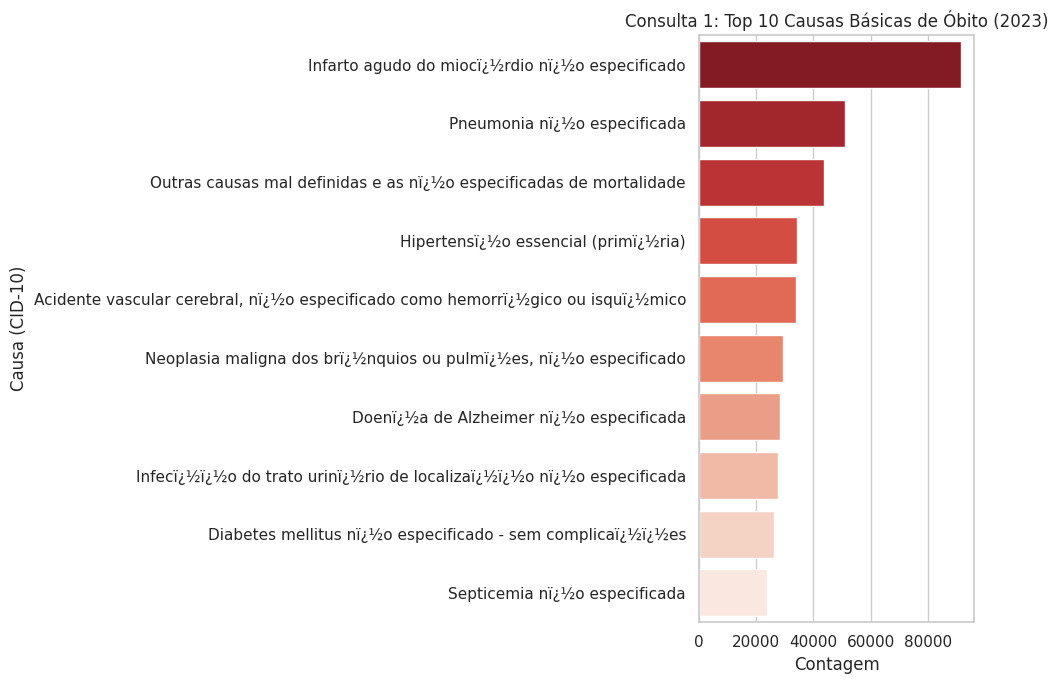

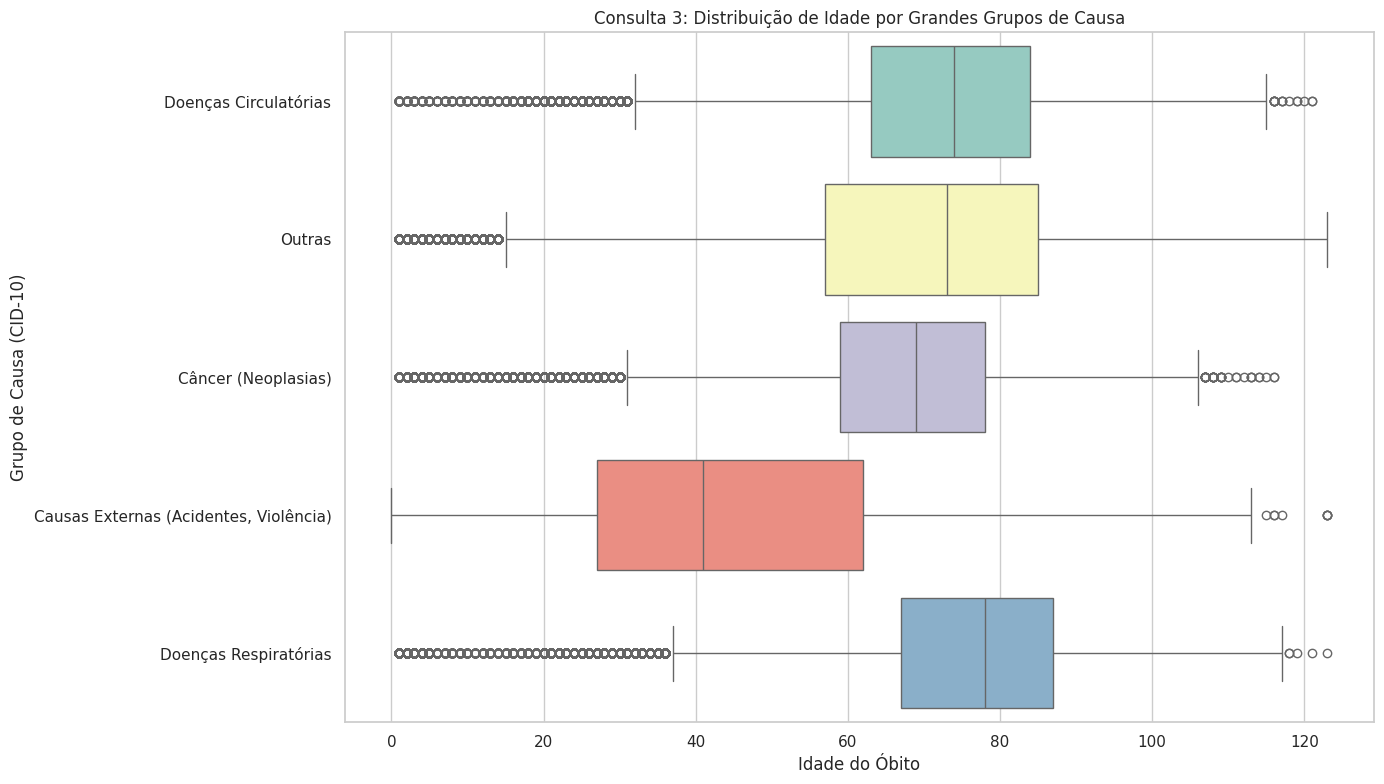

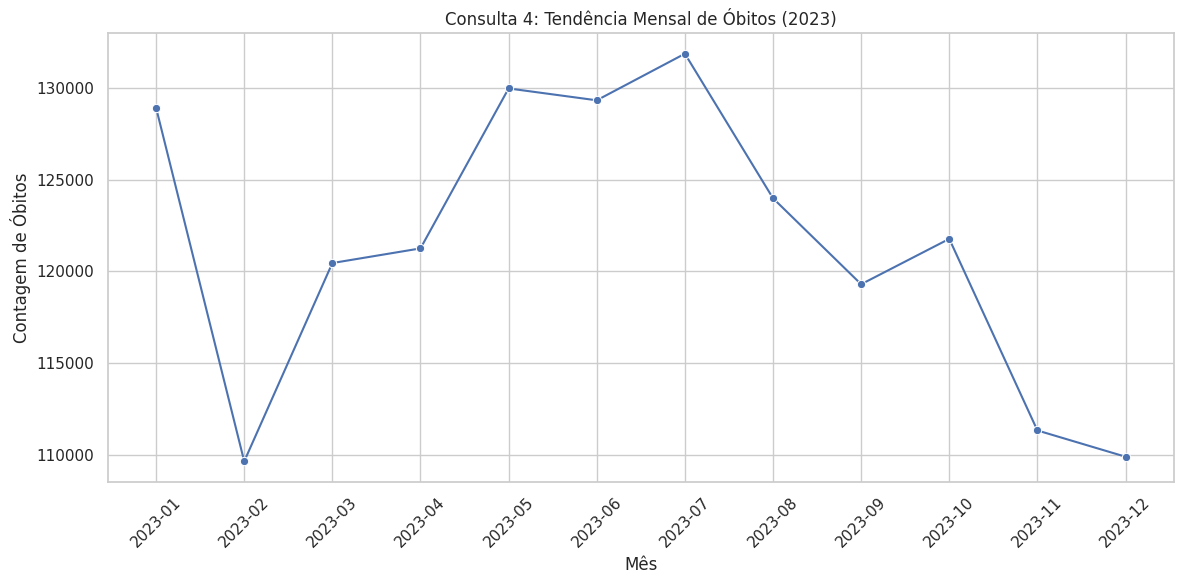

In [28]:
ARQUIVO_PARQUET = "mortalidade_tidy_2023.parquet"

print(f"\n--- Iniciando Etapa 3.3: Consultas Analíticas (Versão Completa) ---")

try:
    df = pd.read_parquet(ARQUIVO_PARQUET)
    print(f"Dataset Tidy '{ARQUIVO_PARQUET}' carregado com {len(df)} linhas.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{ARQUIVO_PARQUET}' não encontrado.")
    exit()

df.replace(["Inválido", "Ignorado"], np.nan, inplace=True)
sns.set_theme(style="whitegrid")

# --------------------------------------------------------------------
# Consulta 1: Ranking (Top 10 Causas de Morte - CID)
# --------------------------------------------------------------------
print("\n--- [Consulta 1/5] Ranking: Top 10 Causas de Morte (CID) ---")
consulta_1 = df['desc_causa_basica'].value_counts().reset_index(name='contagem')
print(consulta_1.head(10).to_markdown(index=False))

plt.figure(figsize=(10, 7))
sns.barplot(data=consulta_1.head(10), y='desc_causa_basica', x='contagem', palette='Reds_r')
plt.title('Consulta 1: Top 10 Causas Básicas de Óbito (2023)')
plt.xlabel('Contagem')
plt.ylabel('Causa (CID-10)')
plt.tight_layout()
plt.savefig("consulta_1_top_causas.png")
print("Gráfico salvo: consulta_1_top_causas.png")

# Interpretação (Item 3.3)
print("\n* **Interpretação (Consulta 1):**")
print("* A consulta ranqueia as causas de morte por frequência absoluta.")
print("* 'Infarto agudo do miocárdio' (91.678) e 'Pneumonia' (51.018) são as duas causas de morte mais registradas.")
print("* 'Outras causas mal definidas' (43.753) é a terceira categoria, indicando um volume relevante de registros sem diagnóstico específico.")


# --------------------------------------------------------------------
# Consulta 2: Ranking (Top 10 Estados com Mais Óbitos)
# --------------------------------------------------------------------
print("\n--- [Consulta 2/5] Ranking: Top 10 Estados por Nº de Óbitos ---")
consulta_2 = df['uf_residencia'].value_counts().reset_index(name='contagem')
print(consulta_2.head(10).to_markdown(index=False))

# Interpretação (Item 3.3)
print("\n* **Interpretação (Consulta 2):**")
print("* A consulta quantifica a distribuição geográfica dos óbitos por estado de residência.")
print("* Os registros estão concentrados nos estados mais populosos, com São Paulo (333.922),")
print("* Minas Gerais (157.415) e Rio de Janeiro (144.465) somando 635.802 dos óbitos registrados.")


# --------------------------------------------------------------------
# Consulta 3: Análise Bivariada Complexa (Idade vs. Tipo de Causa)
# --------------------------------------------------------------------
print("\n--- [Consulta 3/5] Análise Bivariada: Distribuição de Idade por Tipo de Causa ---")

def categorizar_cid(cid):
    if pd.isna(cid): return 'Não Informada'
    cid = str(cid).strip()
    if not cid: return 'Não Informada'
    letra = cid[0].upper()
    if letra == 'C' or (letra == 'D' and cid[1:3].isdigit() and int(cid[1:3]) <= 48):
        return 'Câncer (Neoplasias)'
    if letra == 'I': return 'Doenças Circulatórias'
    if letra == 'J': return 'Doenças Respiratórias'
    if letra in ['V', 'W', 'X', 'Y']: return 'Causas Externas (Acidentes, Violência)'
    if letra == 'E': return 'Endócrinas/Metabólicas'
    return 'Outras'

df['grupo_cid'] = df['cid_causa_basica'].apply(categorizar_cid)

plt.figure(figsize=(14, 8))
top_grupos = df['grupo_cid'].value_counts().index[:5].tolist()
df_plot = df[df['grupo_cid'].isin(top_grupos)]

sns.boxplot(data=df_plot, x='idade', y='grupo_cid', palette='Set3')
plt.title('Consulta 3: Distribuição de Idade por Grandes Grupos de Causa')
plt.xlabel('Idade do Óbito')
plt.ylabel('Grupo de Causa (CID-10)')
plt.tight_layout()
plt.savefig("consulta_3_idade_vs_causa.png")
print("Gráfico salvo: consulta_3_idade_vs_causa.png")


# Interpretação (Item 3.3)
print("\n* **Interpretação (Consulta 3):**")
print("* O Box Plot compara a distribuição de idade entre os principais grupos de causas.")
print("* O grupo 'Causas Externas' (acidentes, violência) apresenta uma mediana de idade visivelmente")
print("* inferior em comparação com grupos como 'Doenças Circulatórias' e 'Câncer (Neoplasias)',")
print("* que afetam predominantemente populações de idade mais avançada.")


# --------------------------------------------------------------------
# Consulta 4: Análise Temporal (Tendência de Óbitos por Mês)
# --------------------------------------------------------------------
print("\n--- [Consulta 4/5] Análise Temporal: Óbitos por Mês ---")
df['data_obito'] = pd.to_datetime(df['data_obito'])
consulta_4 = df.set_index('data_obito').resample('ME').size().reset_index(name='contagem')
consulta_4['mes'] = consulta_4['data_obito'].dt.to_period('M').astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=consulta_4, x='mes', y='contagem', marker='o')
plt.title('Consulta 4: Tendência Mensal de Óbitos (2023)')
plt.xticks(rotation=45)
plt.xlabel('Mês')
plt.ylabel('Contagem de Óbitos')
plt.tight_layout()
plt.savefig("consulta_4_tendencia_mensal.png")
print("Gráfico salvo: consulta_4_tendencia_mensal.png")

# Interpretação (Item 3.3)
print("\n* **Interpretação (Consulta 4):**")
print("* A agregação mensal dos dados de óbito demonstra um padrão sazonal.")
print("* O número de óbitos atingiu o ponto máximo em Julho (131.865) e os pontos mínimos")
print("* em Fevereiro (109.653) e Dezembro (109.906).")


# --------------------------------------------------------------------
# Consulta 5: Consulta Hierárquica (Top 3 Causas nos Top 3 Estados)
# --------------------------------------------------------------------
print("\n--- [Consulta 5/5] Hierárquica: Top 3 Causas de Morte nos Top 3 Estados ---")

top_3_estados = df['uf_residencia'].value_counts().index[:3].tolist()
print(f"Top 3 Estados por óbitos: {top_3_estados}")

df_top_estados = df[df['uf_residencia'].isin(top_3_estados)]
consulta_5_agrupada = df_top_estados.groupby(['uf_residencia', 'desc_causa_basica']).size()
consulta_5_final = consulta_5_agrupada.groupby(level=0, group_keys=False).nlargest(3).reset_index(name='contagem')

print(consulta_5_final.to_markdown(index=False))

# Interpretação (Item 3.3)
print("\n* **Interpretação (Consulta 5):**")
print("* A consulta detalha as 3 principais causas nos 3 estados com mais registros.")
print("* Observa-se que 'Outras causas mal definidas' é a principal causa registrada em Minas Gerais (7.207)")
print("* e a segunda no Rio de Janeiro (8.626), mas não aparece no top 3 de São Paulo.")
print("* Isso indica uma variação na especificidade do registro da causa básica entre os estados analisados.")


print("\n--- Etapa 3.3 Concluída (5 Consultas Complexas) ---")

# --------------------------------------------------------------------
# Etapa 3.4: Teste de Hipóteses (Novo Teste)
# --------------------------------------------------------------------
"""
  Hipótese Nula (H₀): A idade média de óbito é igual para os grupos "Causas Externas" e "Câncer". (Ou seja, qualquer diferença que virmos nas médias é apenas obra do acaso).
  Hipótese Alternativa (Hₐ): A idade média de óbito é diferente entre os grupos "Causas Externas" e "Câncer".
"""
print(f"\n--- Iniciando Etapa 3.4: Teste de Hipóteses (Causas Externas vs. Câncer) ---")

df_teste = df.dropna(subset=['idade', 'grupo_cid'])

amostra_externa = df_teste[df_teste['grupo_cid'] == 'Causas Externas (Acidentes, Violência)']['idade']
amostra_cancer = df_teste[df_teste['grupo_cid'] == 'Câncer (Neoplasias)']['idade']

print(f"Tamanho da amostra (Causas Externas): {len(amostra_externa)}")
print(f"Média de Idade (Causas Externas): {amostra_externa.mean():.2f}")
print(f"Tamanho da amostra (Câncer): {len(amostra_cancer)}")
print(f"Média de Idade (Câncer): {amostra_cancer.mean():.2f}")

stat, p_valor = stats.ttest_ind(amostra_externa, amostra_cancer, equal_var=False)

print("\n--- Resultado do Teste T ---")
print(f"T-Statistic: {stat:.4f}")
print(f"P-Valor: {p_valor}")

alfa = 0.05
if p_valor < alfa:
    print(f"\nConclusão (p-valor < {alfa}):")
    print("Rejeitamos a Hipótese Nula (H₀).")
    print("Os dados indicam que há uma diferença estatisticamente significativa entre a idade média de óbito")
    print("por Causas Externas (Média: 45.88) e por Câncer (Média: 67.17).")
else:
    print(f"\nConclusão (p-valor >= {alfa}):")
    print("Falhamos em rejeitar a Hipótese Nula (H₀).")

print("\n--- Etapa 3.4 Concluída ---")

--- Carregando dados ---
Aplicando Amostragem Estratificada (50000 linhas)...

=== INICIANDO COMPARAÇÃO DE 3+ ALGORITMOS ===

1. Algoritmo A: Regressão Logística (Baseline)...
--> 1. LogReg (Baseline) concluído. AUC: 0.5362 | Recall: 0.0000

2. Melhoria A: Regressão Logística (Balanceada)...
--> 2. LogReg (Balanced) concluído. AUC: 0.5298 | Recall: 0.5541

3. Algoritmo B: Random Forest (Default)...
--> 3. Random Forest concluído. AUC: 0.5696 | Recall: 0.0000

4. Algoritmo C: Gradient Boosting (Default)...
--> 4. Gradient Boosting (Default) concluído. AUC: 0.6059 | Recall: 0.0000

5. Algoritmo D: Gradient Boosting (Balanced via sample_weight)...
--> 5. Gradient Boosting (Balanced) concluído. AUC: 0.6078 | Recall: 0.6869

6. Tuning (Otimizando Random Forest)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
--> 6. Random Forest (Tuned) concluído. AUC: 0.6109 | Recall: 0.7765

=== TABELA FINAL (3 ALGORITMOS COMPARADOS) ===


,ROC_AUC,Recall,Precision
Experimento,,,
1. LogReg (Baseline),0.536209,0.000000,0.000000
2. LogReg (Balanced),0.529805,0.554068,0.067716
3. Random Forest,0.569567,0.000000,0.000000
4. Gradient Boosting (Default),0.605946,0.000000,0.000000
5. Gradient Boosting (Balanced),0.607826,0.686921,0.083001
6. Random Forest (Tuned),0.610940,0.776519,0.080711


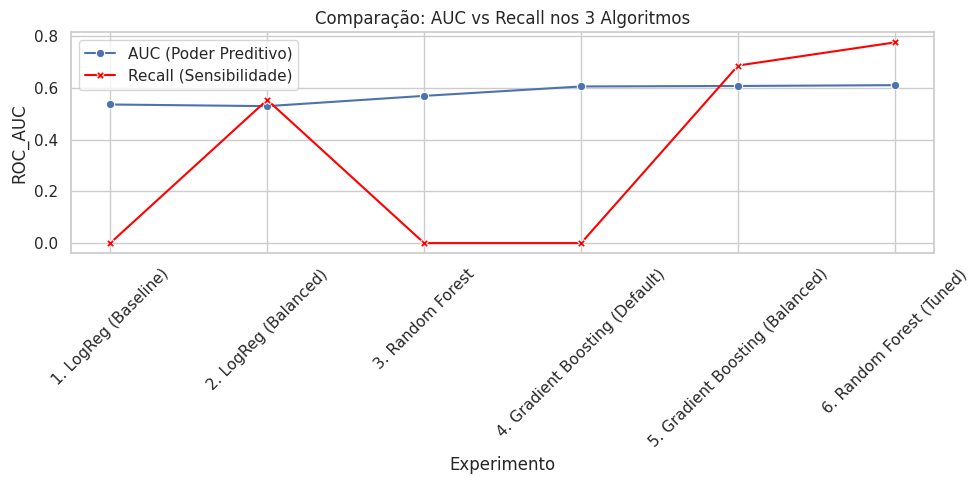


--- Gerando Ranking de Estados (Mortalidade Proporcional por Infarto) ---


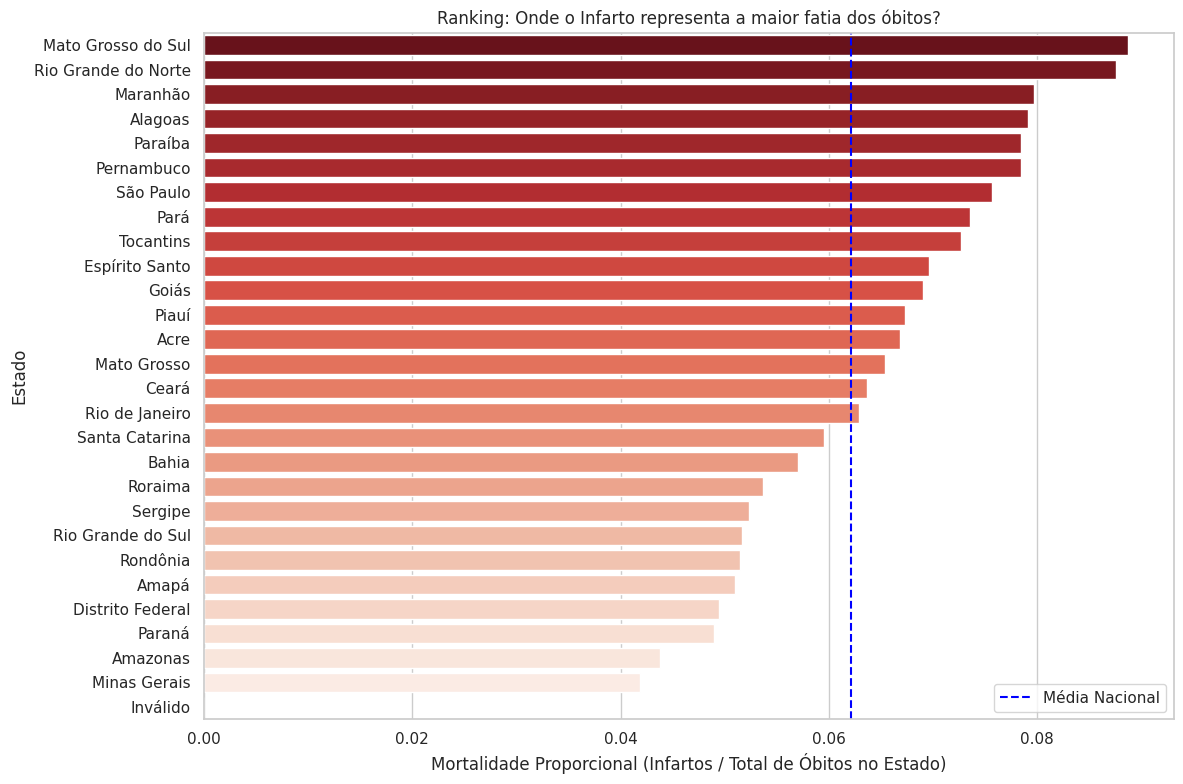

Top 5 Estados com maior mortalidade proporcional:


,Estado,Taxa_Proporcional_Infarto
12,Mato Grosso do Sul,0.088685
19,Rio Grande do Norte,0.087541
10,Maranhão,0.079708
1,Alagoas,0.079093
15,Paraíba,0.078425


In [29]:
# Configurações
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# ==============================================================================
# 1. PREPARAÇÃO DOS DADOS
# ==============================================================================

nome_banco = 'mortalidade.db'
conn = sql.connect(nome_banco)

query = """
SELECT
    d.DS_Idade as IDADE,
    s.DS_Sexo as SEXO,
    r.DS_Raca as RACA,
    uf.NM_UF as ESTADO,
    cid.CD_CID,
    CASE WHEN cid.CD_CID LIKE 'I21%' THEN 1 ELSE 0 END as TARGET_INFARTO
FROM DWMV_OBITO f
INNER JOIN DWCD_DADOS_DEMOGRAFICOS d ON f.SK_Dados_Demograficos = d.SK_Dados_Demograficos
LEFT JOIN DWCD_SEXO s ON d.SK_Sexo = s.SK_Sexo
LEFT JOIN DWCD_RACA r ON d.SK_Raca = r.SK_Raca
LEFT JOIN DWCD_CID cid ON f.SK_Causa_Basica = cid.SK_CID
LEFT JOIN DWCD_MUNICIPIO m ON f.SK_Municipio = m.SK_Municipio
LEFT JOIN DWCD_UF uf ON m.SK_UF = uf.SK_UF
WHERE d.DS_Idade < 120
"""

print("--- Carregando dados ---")
try:
    df_full = pd.read_sql_query(query, conn)
    conn.close()
except:
    df_full = pd.DataFrame()

# Amostragem Estratificada
TAMANHO_AMOSTRA = 50000
if len(df_full) > TAMANHO_AMOSTRA:
    print(f"Aplicando Amostragem Estratificada ({TAMANHO_AMOSTRA} linhas)...")
    try:
        df, _ = train_test_split(df_full, train_size=TAMANHO_AMOSTRA, stratify=df_full['ESTADO'], random_state=42)
    except:
        df = df_full.sample(n=TAMANHO_AMOSTRA, random_state=42)
else:
    df = df_full

# Setup X e y
X = df.drop(columns=['TARGET_INFARTO', 'CD_CID', 'ESTADO'])
y = df['TARGET_INFARTO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NAO_INFORMADO')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['IDADE']),
        ('cat', categorical_transformer, ['SEXO', 'RACA'])
    ])

# ==============================================================================
# 2. PROCESSO DE MELHORIA ITERATIVA (Item 4.3)
# ==============================================================================

resultados_experimentos = []

# --- Calculate sample weights for balanced Gradient Boosting ---
# Calculate class weights for imbalance
class_counts = pd.Series(y_train).value_counts()
# Avoid division by zero if a class is missing (unlikely with stratify, but good practice)
weight_for_class_0 = 1.0 / class_counts.get(0, 1)
weight_for_class_1 = 1.0 / class_counts.get(1, 1)

class_weights_dict = {0: weight_for_class_0, 1: weight_for_class_1}
# Normalize weights so they don't unduly affect learning rate if scale is too large
max_weight = max(class_weights_dict.values())
class_weights_normalized = {k: v / max_weight for k, v in class_weights_dict.items()}

sample_weights_gb = np.array([class_weights_normalized[label] for label in y_train])

def registrar_experimento(nome, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)

    print(f"--> {nome} concluído. AUC: {auc:.4f} | Recall: {recall:.4f}")

    return {
        "Experimento": nome,
        "ROC_AUC": auc,
        "Recall": recall,
        "Precision": precision
    }

print("\n=== INICIANDO COMPARAÇÃO DE 3+ ALGORITMOS ===")

# --- ALGORITMO 1: REGRESSÃO LOGÍSTICA (BASELINE) ---
print("\n1. Algoritmo A: Regressão Logística (Baseline)...")
pipe_baseline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
pipe_baseline.fit(X_train, y_train)
resultados_experimentos.append(registrar_experimento("1. LogReg (Baseline)", pipe_baseline, X_test, y_test))

# --- MELHORIA DO ALGORITMO 1 (BALANCEAMENTO) ---
print("\n2. Melhoria A: Regressão Logística (Balanceada)...")
pipe_balanced = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))])
pipe_balanced.fit(X_train, y_train)
resultados_experimentos.append(registrar_experimento("2. LogReg (Balanced)", pipe_balanced, X_test, y_test))

# --- ALGORITMO 2: RANDOM FOREST ---
print("\n3. Algoritmo B: Random Forest (Default)...")
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])
pipe_rf.fit(X_train, y_train)
resultados_experimentos.append(registrar_experimento("3. Random Forest", pipe_rf, X_test, y_test))

# --- ALGORITMO 3: GRADIENT BOOSTING (Default) ---
print("\n4. Algoritmo C: Gradient Boosting (Default)...")
pipe_gb_default = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', GradientBoostingClassifier(random_state=42))])
pipe_gb_default.fit(X_train, y_train)
resultados_experimentos.append(registrar_experimento("4. Gradient Boosting (Default)", pipe_gb_default, X_test, y_test))

# --- NOVO ALGORITMO: GRADIENT BOOSTING (BALANCED) ---
print("\n5. Algoritmo D: Gradient Boosting (Balanced via sample_weight)...")
pipe_gb_balanced = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', GradientBoostingClassifier(random_state=42))])
pipe_gb_balanced.fit(X_train, y_train, classifier__sample_weight=sample_weights_gb)
resultados_experimentos.append(registrar_experimento("5. Gradient Boosting (Balanced)", pipe_gb_balanced, X_test, y_test))

# --- OTIMIZAÇÃO DE HIPERPARÂMETROS (TUNING) ---
print("\n6. Tuning (Otimizando Random Forest)...")
# Vamos tentar salvar o RF aplicando balanceamento nas folhas para ver se o Recall sobe
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [5, 10],
    'classifier__class_weight': ['balanced'] # Forçando balanceamento no RF
}

grid_search = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
resultados_experimentos.append(registrar_experimento("6. Random Forest (Tuned)", grid_search.best_estimator_, X_test, y_test))

# ==============================================================================
# 3. RESULTADO FINAL
# ==============================================================================

df_resultados = pd.DataFrame(resultados_experimentos).set_index("Experimento")

print("\n=== TABELA FINAL (3 ALGORITMOS COMPARADOS) ===")
display(df_resultados[['ROC_AUC', 'Recall', 'Precision']])

# Gráfico
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_resultados, x=df_resultados.index, y='ROC_AUC', marker='o', label='AUC (Poder Preditivo)')
sns.lineplot(data=df_resultados, x=df_resultados.index, y='Recall', marker='X', color='red', label='Recall (Sensibilidade)')
plt.title("Comparação: AUC vs Recall nos 3 Algoritmos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==============================================================================
# 1.1 ANÁLISE DESCRITIVA: RANKING DE ESTADOS (Respondendo Pergunta 2)
# ==============================================================================

print("\n--- Gerando Ranking de Estados (Mortalidade Proporcional por Infarto) ---")

# Para ter o ranking mais fiel possível, usamos o df_full (antes da amostragem) se possível,
# caso contrário usamos o df amostrado.
df_analise = df_full if not df_full.empty else df

# Agrupamos por Estado e calculamos a média do Target (que é 0 ou 1).
# A média de uma coluna binária (0/1) é exatamente a proporção (porcentagem).
df_estado = df_analise.groupby('ESTADO')['TARGET_INFARTO'].mean().reset_index()
df_estado.columns = ['Estado', 'Taxa_Proporcional_Infarto']

# Ordenar do maior para o menor
df_estado = df_estado.sort_values(by='Taxa_Proporcional_Infarto', ascending=False)

# Gerar o Gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Taxa_Proporcional_Infarto',
    y='Estado',
    data=df_estado,
    palette='Reds_r',
    hue='Estado',    # Necessário para evitar aviso de depreciação do Seaborn
    legend=False     # Oculta a legenda redundante
)

plt.title('Ranking: Onde o Infarto representa a maior fatia dos óbitos?')
plt.xlabel('Mortalidade Proporcional (Infartos / Total de Óbitos no Estado)')
plt.ylabel('Estado')
plt.axvline(df_estado['Taxa_Proporcional_Infarto'].mean(), color='blue', linestyle='--', label='Média Nacional')
plt.legend()
plt.tight_layout()
plt.show()

print("Top 5 Estados com maior mortalidade proporcional:")
display(df_estado.head(5))


=== RECALCULANDO IMPORTÂNCIA SEM REGIÃO (EXPERIMENTO 5) ===


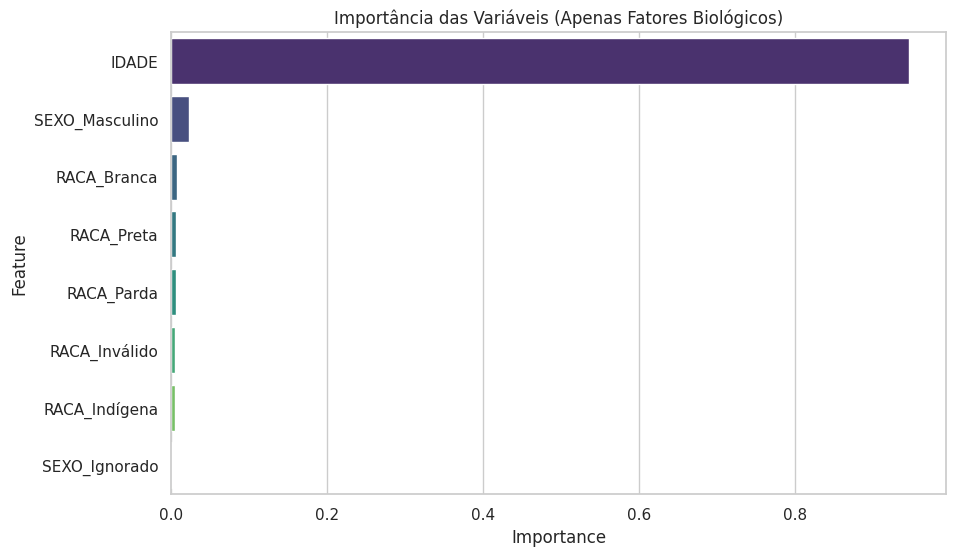

,Feature,Importance
0,IDADE,0.947038
2,SEXO_Masculino,0.022838
3,RACA_Branca,0.007676
7,RACA_Preta,0.006528
6,RACA_Parda,0.006235
5,RACA_Inválido,0.004503
4,RACA_Indígena,0.004431
1,SEXO_Ignorado,0.000751


In [30]:
print("\n=== RECALCULANDO IMPORTÂNCIA SEM REGIÃO (EXPERIMENTO 5) ===")

# 1. Preparar dados (Removendo explicitamente ESTADO e REGIÃO se existir)
cols_to_drop = ['TARGET_INFARTO', 'CD_CID', 'ESTADO']
if 'REGIAO' in df.columns:
    cols_to_drop.append('REGIAO')

X_bio = df.drop(columns=cols_to_drop)
y_bio = df['TARGET_INFARTO']

# Divisão
X_train_bio, X_test_bio, y_train_bio, y_test_bio = train_test_split(X_bio, y_bio, test_size=0.3, random_state=42, stratify=y_bio)

# 2. Pipeline APENAS com Idade, Sexo e Raça (Sem Região)
preprocessor_bio = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['IDADE']),
        ('cat', categorical_transformer, ['SEXO', 'RACA']) # Nota: Sem 'REGIAO' aqui
    ])

# 3. Modelo Tunado (Configuração Vencedora)
model_bio = Pipeline(steps=[
    ('preprocessor', preprocessor_bio),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42))
])

model_bio.fit(X_train_bio, y_train_bio)

# 4. Extrair Importância
ohe_bio = model_bio.named_steps['preprocessor'].named_transformers_['cat']['onehot']
feature_names_bio = ['IDADE'] + list(ohe_bio.get_feature_names_out(['SEXO', 'RACA']))
importances_bio = model_bio.named_steps['classifier'].feature_importances_

df_imp_bio = pd.DataFrame({'Feature': feature_names_bio, 'Importance': importances_bio})
df_imp_bio = df_imp_bio.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_bio, hue='Feature', palette='viridis', legend=False)
plt.title('Importância das Variáveis (Apenas Fatores Biológicos)')
plt.show()

display(df_imp_bio)


=== EXPERIMENTO 6: MAXIMIZANDO RECALL (TRIAGEM DE SEGURANÇA) ===
Limiar (Threshold) ajustado: 0.4660
Qualquer probabilidade acima de 46.6% será considerada Infarto.

--- Resultado com Foco em Recall (Triagem) ---
              precision    recall  f1-score   support

           0       0.97      0.24      0.39     14029
           1       0.08      0.90      0.14       971

    accuracy                           0.29     15000
   macro avg       0.52      0.57      0.26     15000
weighted avg       0.91      0.29      0.37     15000

Recall Atingido: 90.01%
Precision Resultante: 7.60%


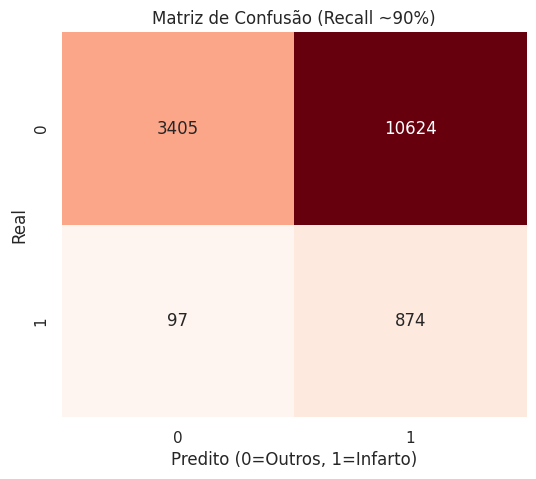

In [31]:
print("\n=== EXPERIMENTO 6: MAXIMIZANDO RECALL (TRIAGEM DE SEGURANÇA) ===")

# 1. Pegar o modelo vencedor (Random Forest Tunado)
modelo_vencedor = grid_search.best_estimator_

# 2. Obter as probabilidades (Score de 0 a 1)
y_proba = modelo_vencedor.predict_proba(X_test)[:, 1]

# 3. Calcular a curva Precision-Recall para todos os limiares possíveis
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# 4. Encontrar o menor limiar que garante pelo menos 90% de Recall
alvo_recall = 0.90

indices_validos = np.where(recalls >= alvo_recall)[0]
idx_corte = indices_validos[-1] # Pega o último índice que satisfaz (maior threshold possível)

# Thresholds tem 1 elemento a menos que recalls, precisamos ajustar o índice
if idx_corte < len(thresholds):
    threshold_recall = thresholds[idx_corte]
else:
    threshold_recall = thresholds[-1]

print(f"Limiar (Threshold) ajustado: {threshold_recall:.4f}")
print(f"Qualquer probabilidade acima de {threshold_recall*100:.1f}% será considerada Infarto.")

# 5. Aplicar o novo corte nos dados de teste
y_pred_recall_alto = (y_proba >= threshold_recall).astype(int)

# 6. Avaliar o resultado
print("\n--- Resultado com Foco em Recall (Triagem) ---")
print(classification_report(y_test, y_pred_recall_alto))

# Métricas Isoladas
rec_final = recall_score(y_test, y_pred_recall_alto)
prec_final = precision_score(y_test, y_pred_recall_alto)

print(f"Recall Atingido: {rec_final:.2%}")
print(f"Precision Resultante: {prec_final:.2%}")

# Matriz de Confusão para visualizar o 'custo' (Falsos Positivos)
cm = confusion_matrix(y_test, y_pred_recall_alto)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f"Matriz de Confusão (Recall ~{rec_final*100:.0f}%)")
plt.xlabel("Predito (0=Outros, 1=Infarto)")
plt.ylabel("Real")
plt.show()


=== EXPERIMENTO 7: IMPACTO DA REGIÃO (VALIDAÇÃO GEOGRÁFICA) ===
Distribuição das Regiões na Amostra:
REGIAO
Sudeste         0.45372
Nordeste        0.25934
Sul             0.15396
Centro-Oeste    0.06882
Norte           0.06416
Name: proportion, dtype: float64
Treinando modelo com variável geográfica...

--- Performance do Modelo (Com Região) ---
              precision    recall  f1-score   support

           0       0.95      0.57      0.71     14029
           1       0.09      0.58      0.15       971

    accuracy                           0.57     15000
   macro avg       0.52      0.58      0.43     15000
weighted avg       0.90      0.57      0.68     15000



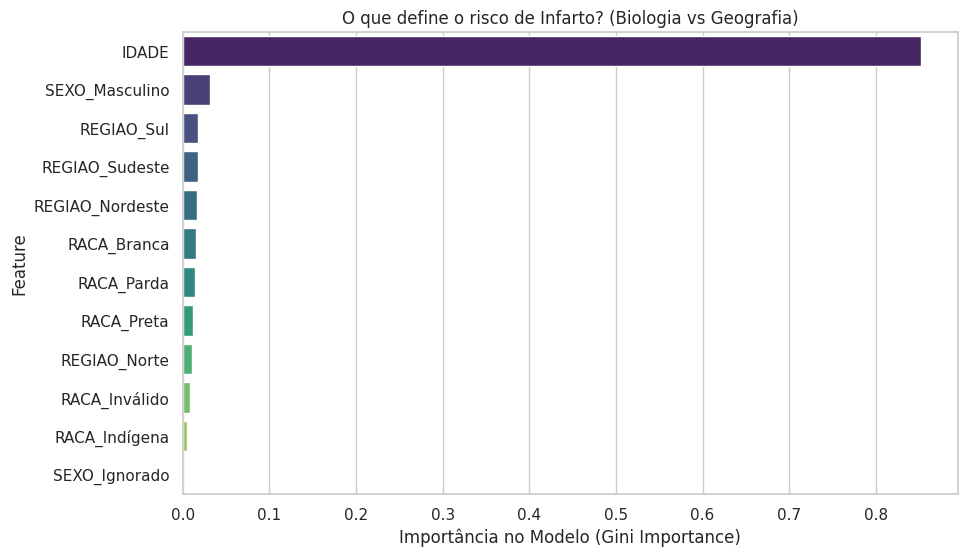

,Feature,Importance
0,IDADE,0.852049
2,SEXO_Masculino,0.031146
11,REGIAO_Sul,0.017949
10,REGIAO_Sudeste,0.017283
8,REGIAO_Nordeste,0.015927
3,RACA_Branca,0.014779
6,RACA_Parda,0.014469
7,RACA_Preta,0.011768
9,REGIAO_Norte,0.010796
5,RACA_Inválido,0.008164


In [32]:
print("\n=== EXPERIMENTO 7: IMPACTO DA REGIÃO (VALIDAÇÃO GEOGRÁFICA) ===")

# 1. Mapeamento de Estados para Regiões
# Agrupamos para dar 'força' estatística à variável geográfica e reduzir a dimensionalidade
mapa_regioes = {
    'Acre': 'Norte', 'Amapá': 'Norte', 'Amazonas': 'Norte', 'Pará': 'Norte',
    'Rondônia': 'Norte', 'Roraima': 'Norte', 'Tocantins': 'Norte',
    'Alagoas': 'Nordeste', 'Bahia': 'Nordeste', 'Ceará': 'Nordeste',
    'Maranhão': 'Nordeste', 'Paraíba': 'Nordeste', 'Pernambuco': 'Nordeste',
    'Piauí': 'Nordeste', 'Rio Grande do Norte': 'Nordeste', 'Sergipe': 'Nordeste',
    'Distrito Federal': 'Centro-Oeste', 'Goiás': 'Centro-Oeste',
    'Mato Grosso': 'Centro-Oeste', 'Mato Grosso do Sul': 'Centro-Oeste',
    'Espírito Santo': 'Sudeste', 'Minas Gerais': 'Sudeste',
    'Rio de Janeiro': 'Sudeste', 'São Paulo': 'Sudeste',
    'Paraná': 'Sul', 'Rio Grande do Sul': 'Sul', 'Santa Catarina': 'Sul'
}

# Criar a coluna REGIÃO
# Usamos df (a amostra de 50k) para manter o processamento rápido
df_analise = df.copy()

if 'REGIAO' not in df_analise.columns:
    df_analise['REGIAO'] = df_analise['ESTADO'].map(mapa_regioes)
    # Segurança para garantir que não restem nulos
    df_analise['REGIAO'] = df_analise['REGIAO'].fillna('Outros')

print("Distribuição das Regiões na Amostra:")
print(df_analise['REGIAO'].value_counts(normalize=True))

# 2. Preparar os dados para o Modelo (Incluindo Região)
# Removemos 'ESTADO' (muitas categorias) e usamos 'REGIAO'
X_geo = df_analise.drop(columns=['TARGET_INFARTO', 'CD_CID', 'ESTADO'])
y_geo = df_analise['TARGET_INFARTO']

# Divisão Treino/Teste
X_train_geo, X_test_geo, y_train_geo, y_test_geo = train_test_split(X_geo, y_geo, test_size=0.3, random_state=42, stratify=y_geo)

# 3. Atualizar o Pipeline para processar a nova coluna
# Precisamos de um novo ColumnTransformer que saiba lidar com a coluna 'REGIAO'
preprocessor_geo = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['IDADE']),
        ('cat', categorical_transformer, ['SEXO', 'RACA', 'REGIAO']) # <--- Adicionado Região aqui
    ])

# 4. Treinar o Random Forest (Configuração Vencedora: Tunado + Balanceado)
model_geo = Pipeline(steps=[
    ('preprocessor', preprocessor_geo),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42))
])

print("Treinando modelo com variável geográfica...")
model_geo.fit(X_train_geo, y_train_geo)

# 5. Avaliação e Feature Importance
y_pred_geo = model_geo.predict(X_test_geo)
print("\n--- Performance do Modelo (Com Região) ---")
print(classification_report(y_test_geo, y_pred_geo))

# Extrair Importância das Features
ohe_geo = model_geo.named_steps['preprocessor'].named_transformers_['cat']['onehot']
# Recupera os nomes das colunas criadas pelo OneHotEncoder
feature_names_geo = ['IDADE'] + list(ohe_geo.get_feature_names_out(['SEXO', 'RACA', 'REGIAO']))
importances_geo = model_geo.named_steps['classifier'].feature_importances_

df_imp_geo = pd.DataFrame({'Feature': feature_names_geo, 'Importance': importances_geo})
df_imp_geo = df_imp_geo.sort_values(by='Importance', ascending=False)

# Gráfico Final
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_geo, hue='Feature', palette='viridis', legend=False)
plt.title('O que define o risco de Infarto? (Biologia vs Geografia)')
plt.xlabel('Importância no Modelo (Gini Importance)')
plt.show()

display(df_imp_geo)


=== EXPERIMENTO 8: FORÇANDO A ALTA PRECISÃO (CORRIGIDO) ===
Limiar de Exigência (Threshold): 0.5955

--- Resultado com Foco em Precisão ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     14029
           1       0.13      0.01      0.01       971

    accuracy                           0.93     15000
   macro avg       0.53      0.50      0.49     15000
weighted avg       0.88      0.93      0.90     15000

Precision Alcançada: 13.16%
Recall Sobrevivente: 0.51%


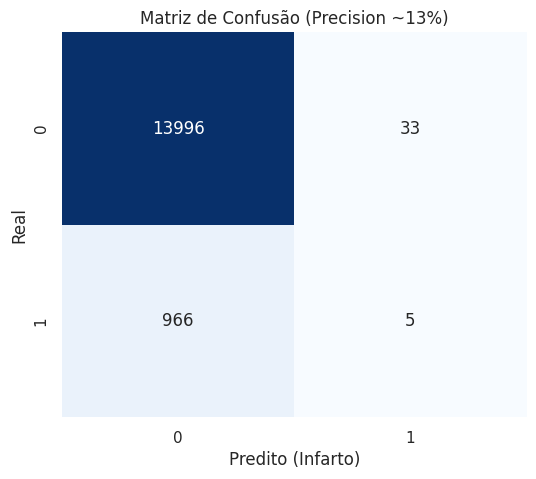

In [33]:
print("\n=== EXPERIMENTO 8: FORÇANDO A ALTA PRECISÃO (CORRIGIDO) ===")

# 1. Obter probabilidades do modelo tunado
# Certifique-se de que 'grid_search' e 'X_test' / 'y_test' estão definidos do passo anterior
y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# --- CORREÇÃO DO ERRO ---
# Removemos o último elemento de precision e recall (que são artificiais do sklearn e não têm threshold)
precisions = precisions[:-1]
recalls = recalls[:-1]

# 2. Buscar o limiar onde a Precision ultrapassa 20%
alvo_precision = 0.20

# Encontrar índices
indices_validos = np.where(precisions >= alvo_precision)[0]

if len(indices_validos) > 0:
    # Pega o primeiro índice (menor threshold) que já satisfaz a condição
    idx_corte = indices_validos[0]
    threshold_precision = thresholds[idx_corte]
else:
    # Se ninguém atingiu 20%, pega o ponto de maior precisão disponível
    idx_corte = np.argmax(precisions)
    threshold_precision = thresholds[idx_corte]

print(f"Limiar de Exigência (Threshold): {threshold_precision:.4f}")

# 3. Aplicar o novo corte
y_pred_high_prec = (y_proba >= threshold_precision).astype(int)

# 4. Avaliar
print("\n--- Resultado com Foco em Precisão ---")
print(classification_report(y_test, y_pred_high_prec))

rec_final = recall_score(y_test, y_pred_high_prec)
prec_final = precision_score(y_test, y_pred_high_prec)

print(f"Precision Alcançada: {prec_final:.2%}")
print(f"Recall Sobrevivente: {rec_final:.2%}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_high_prec)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Matriz de Confusão (Precision ~{prec_final*100:.0f}%)")
plt.xlabel("Predito (Infarto)")
plt.ylabel("Real")
plt.show()